In [ ]:
pip install optuna

In [ ]:
pip install lime

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, roc_auc_score, recall_score,f1_score, precision_recall_curve, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import stats
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cardiac Arrest Dataset

In [ ]:
dfca = pd.read_csv('/content/drive/My Drive/capstone/undersampled_CDARREST_Knee_21_22_23(2).csv')

In [ ]:
dfca.head()

SEX  RACE_NEW  INOUT  Age  ASACLAS  CPT  ANESTHES  SMOKE  HXCOPD  HXCHF  \
0    0         6      1    3      3.0    2       1.0      0       0      0   
1    0         1      1    4      3.0    2       3.0      0       1      0   
2    0         1      0    2      2.0    2       1.0      1       0      0   
3    0         1      0    3      2.0    2       1.0      0       0      0   
4    0         1      1    3      3.0    2       3.0      0       0      0   

   ...  OTHDVT  PULEMBOL  CDARREST  CDMI  REINTUB  FAILWEAN  OUPNEUMO  \
0  ...       0         0         0     0        0         0         0   
1  ...       0         0         0     0        0         0         0   
2  ...       0         0         0     0        0         0         0   
3  ...       0         0         0     0        0         0         0   
4  ...       0         0         0     0        0         0         0   

   DIABETES    BMI  Year  
0         0  41.62  2023  
1         1  33.41  2022  
2         0  31.00  2021  
3         0  21.76  2022  
4         0  39.38  2022  

[5 rows x 28 columns]

# CDMI Dataset

In [ ]:
dfcdmi = pd.read_csv('/content/drive/My Drive/capstone/undersampled_CDMI_Knee_21_22_23(2).csv')

In [ ]:
dfcdmi.head()

SEX  RACE_NEW  INOUT  Age  ASACLAS  CPT  ANESTHES  SMOKE  HXCOPD  HXCHF  \
0    0         1      1    3      3.0    2       1.0      0       0      0   
1    1         6      1    3      2.0    2       2.0      0       0      0   
2    1         1      0    3      3.0    2       2.0      0       0      0   
3    1         1      0    3      3.0    2       1.0      0       0      0   
4    0         1      0    3      2.0    2       2.0      0       0      0   

   ...  OTHDVT  PULEMBOL  CDARREST  CDMI  REINTUB  FAILWEAN  OUPNEUMO  \
0  ...       0         0         0     0        0         0         0   
1  ...       0         0         0     0        0         0         0   
2  ...       0         0         0     0        0         0         0   
3  ...       0         0         0     0        0         0         0   
4  ...       0         0         0     0        0         0         0   

   DIABETES    BMI  Year  
0         0  29.45  2022  
1         0  44.35  2021  
2         0  25.84  2023  
3         1  34.21  2023  
4         0  34.95  2022  

[5 rows x 28 columns]

# Random Forest

## Cardiac Arrest

This code builds and evaluates a Random Forest model to predict cardiac arrest (CDARREST). Optuna is used to tune hyperparameters for the model by maximizing the area under the ROC curve (AUC) through 5-fold cross-validation. After finding the best parameters, it retrains the model, evaluates its performance (AUC, accuracy, F1, recall, precision), and plots the ROC curve to visualize how well the model distinguishes between positive and negative cases.

[I 2025-03-21 16:33:41,662] A new study created in memory with name: no-name-a51ebf6c-64db-4d38-8210-be715f08965e
[I 2025-03-21 16:33:45,263] Trial 0 finished with value: 0.8726654064272211 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 0 with value: 0.8726654064272211.
[I 2025-03-21 16:33:49,338] Trial 1 finished with value: 0.8886956521739131 and parameters: {'n_estimators': 165, 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8886956521739131.
[I 2025-03-21 16:33:52,420] Trial 2 finished with value: 0.8864272211720227 and parameters: {'n_estimators': 197, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8886956521739131.
[I 2025-03-21 16:33:56,666] Trial 3 finished with value: 0.8635916824196598 and parameters: {'n_estimators': 181, 'max_depth': 14, 'm

Best hyperparameters:  {'n_estimators': 65, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


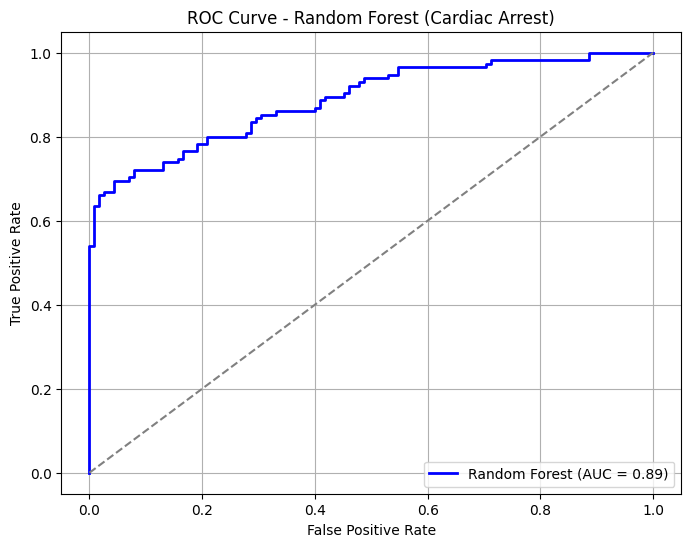

Random Forest Metrics for Cardiac Arrest: 
AUC Score: 0.8875
Accuracy: 0.8130
F1 Score: 0.7882
Recall: 0.6957
Precision: 0.9091


In [ ]:
X_RF_CA = dfca.drop(columns=['CDARREST'])
y_RF_CA = dfca['CDARREST']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf_classifier_CA = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight='balanced',
        random_state=42
)

    kf_RF_CA = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_prob_RF_CA = cross_val_predict(rf_classifier_CA, X_RF_CA, y_RF_CA, cv=kf_RF_CA, method="predict_proba")[:, 1]

    fpr_RF_CA, tpr_RF_CA, _ = roc_curve(y_RF_CA, y_pred_prob_RF_CA)
    roc_auc_RF_CA = auc(fpr_RF_CA, tpr_RF_CA)

    return roc_auc_RF_CA

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters: ', study.best_params)

best_params = study.best_params
rf_classifier_CA = RandomForestClassifier(**best_params, random_state=42)

kf_RF_CA = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_prob_RF_CA = cross_val_predict(rf_classifier_CA, X_RF_CA, y_RF_CA, cv=kf_RF_CA, method="predict_proba")[:, 1]
y_pred_RF_CA = cross_val_predict(rf_classifier_CA, X_RF_CA, y_RF_CA, cv=kf_RF_CA, method="predict")

fpr_RF_CA, tpr_RF_CA, _ = roc_curve(y_RF_CA, y_pred_prob_RF_CA)
roc_auc_RF_CA = auc(fpr_RF_CA, tpr_RF_CA)

accuracy_RF_CA = accuracy_score(y_RF_CA, y_pred_RF_CA)
f1_RF_CA = f1_score(y_RF_CA, y_pred_RF_CA)
recall_RF_CA = recall_score(y_RF_CA, y_pred_RF_CA)
precision_RF_CA = precision_score(y_RF_CA, y_pred_RF_CA)

plt.figure(figsize=(8, 6))
plt.plot(fpr_RF_CA, tpr_RF_CA, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_RF_CA:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Cardiac Arrest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'Random Forest Metrics for Cardiac Arrest: ')
print(f'AUC Score: {roc_auc_RF_CA:.4f}')
print(f'Accuracy: {accuracy_RF_CA:.4f}')
print(f'F1 Score: {f1_RF_CA:.4f}')
print(f'Recall: {recall_RF_CA:.4f}')
print(f'Precision: {precision_RF_CA:.4f}')

In [ ]:
rf_classifier_CA.fit(X_RF_CA, y_RF_CA)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=11,
                       n_estimators=65, random_state=42)

The below code generates a SHAP summary plot to interpret the Random Forest model predicting cardiac arrest. It uses SHAP (SHapley Additive exPlanations) to calculate each feature's contribution to the model's predictions. The summary plot visually ranks features by importance and shows how they impact the output, helping to understand which variables most influence the risk of cardiac arrest.

In [ ]:
explainer_RF_CA = shap.TreeExplainer(rf_classifier_CA)
shap_values_RF_CA = explainer_RF_CA.shap_values(X_RF_CA)


feature_names = X_RF_CA.columns

plt.figure(figsize=(18, 6))
shap.summary_plot(shap_values_RF_CA, X_RF_CA, feature_names=feature_names, plot_size=(2, 0.5), show=False)

plt.suptitle("SHAP Summary Plot - Random Forest (CA)", fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.2, bottom=0.2, left=0.2)

plt.show()

The below code creates a LIME (Local Interpretable Model-agnostic Explanations) explanation for a single, randomly selected patient in the cardiac arrest dataset. It explains how the Random Forest model made its prediction for that specific case by showing the contribution of individual features to the predicted probability. The resulting plot visually breaks down which features pushed the prediction toward or away from a cardiac arrest classification.

In [ ]:
lime_explainer_RF_CA = LimeTabularExplainer(
    training_data=X_RF_CA.values,
    feature_names=X_RF_CA.columns.tolist(),
    class_names=['No Arrest', 'Arrest'],
    mode='classification'
)

idx_RF_CA = np.random.randint(0, X_RF_CA.shape[0])
lime_exp_RF_CA = lime_explainer_RF_CA.explain_instance(
    X_RF_CA.iloc[idx_RF_CA],
    rf_classifier_CA.predict_proba
)

lime_exp_RF_CA.show_in_notebook()

fig = lime_exp_RF_CA.as_pyplot_figure()
plt.show()

## CDMI

Similarly, this code builds and evaluates a Random Forest model to predict myocardial infarction (CDMI). Optuna is used to tune hyperparameters for the model by maximizing the area under the ROC curve (AUC) through 5-fold cross-validation. After finding the best parameters, it retrains the model, evaluates its performance (AUC, accuracy, F1, recall, precision), and plots the ROC curve to visualize how well the model distinguishes between positive and negative cases.

[I 2025-03-21 16:34:58,182] A new study created in memory with name: no-name-f11389b8-0419-42d2-a6d1-1dae7d0e7030
[I 2025-03-21 16:34:59,283] Trial 0 finished with value: 0.7939172630134301 and parameters: {'n_estimators': 108, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7939172630134301.
[I 2025-03-21 16:35:01,086] Trial 1 finished with value: 0.7920056857170865 and parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7939172630134301.
[I 2025-03-21 16:35:03,555] Trial 2 finished with value: 0.7718238407999216 and parameters: {'n_estimators': 161, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 0 with value: 0.7939172630134301.
[I 2025-03-21 16:35:04,615] Trial 3 finished with value: 0.8012939907852171 and parameters: {'n_estimators': 117, 'max_depth': 3, 'mi

Best hyperparameters:  {'n_estimators': 171, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}


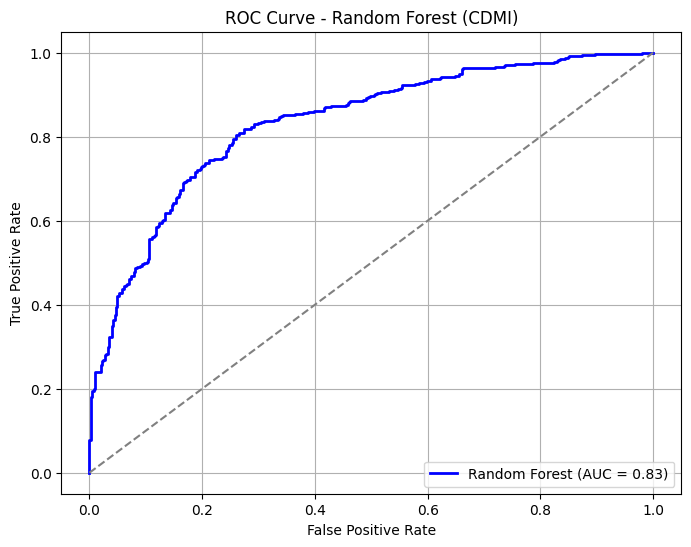

Random Forest Metrics for CDMI: 
AUC Score: 0.8330
Accuracy: 0.7574
F1 Score: 0.7556
Recall: 0.7500
Precision: 0.7613


In [ ]:
X_RF_CDMI = dfcdmi.drop(columns=['CDMI'])
y_RF_CDMI = dfcdmi['CDMI']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf_classifier_CDMI = RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      max_features=max_features,
      class_weight='balanced',
      random_state=42
  )

    kf_RF_CDMI = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_prob_RF_CDMI = cross_val_predict(rf_classifier_CDMI, X_RF_CDMI, y_RF_CDMI, cv=kf_RF_CDMI, method="predict_proba")[:, 1]

    fpr_RF_CDMI, tpr_RF_CDMI, _ = roc_curve(y_RF_CDMI, y_pred_prob_RF_CDMI)
    roc_auc_RF_CDMI = auc(fpr_RF_CDMI, tpr_RF_CDMI)

    return roc_auc_RF_CDMI

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters: ', study.best_params)

best_params = study.best_params
rf_classifier_CDMI = RandomForestClassifier(**best_params, random_state=42)

kf_RF_CDMI = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_prob_RF_CDMI = cross_val_predict(rf_classifier_CDMI, X_RF_CDMI, y_RF_CDMI, cv=kf_RF_CDMI, method="predict_proba")[:, 1]
y_pred_RF_CDMI = cross_val_predict(rf_classifier_CDMI, X_RF_CDMI, y_RF_CDMI, cv=kf_RF_CDMI, method="predict")

fpr_RF_CDMI, tpr_RF_CDMI, _ = roc_curve(y_RF_CDMI, y_pred_prob_RF_CDMI)
roc_auc_RF_CDMI = auc(fpr_RF_CDMI, tpr_RF_CDMI)

accuracy_RF_CDMI = accuracy_score(y_RF_CDMI, y_pred_RF_CDMI)
f1_RF_CDMI = f1_score(y_RF_CDMI, y_pred_RF_CDMI)
recall_RF_CDMI = recall_score(y_RF_CDMI, y_pred_RF_CDMI)
precision_RF_CDMI = precision_score(y_RF_CDMI, y_pred_RF_CDMI)


plt.figure(figsize=(8, 6))
plt.plot(fpr_RF_CDMI, tpr_RF_CDMI, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_RF_CDMI:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (CDMI)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'Random Forest Metrics for CDMI: ')
print(f'AUC Score: {roc_auc_RF_CDMI:.4f}')
print(f'Accuracy: {accuracy_RF_CDMI:.4f}')
print(f'F1 Score: {f1_RF_CDMI:.4f}')
print(f'Recall: {recall_RF_CDMI:.4f}')
print(f'Precision: {precision_RF_CDMI:.4f}')

In [ ]:
rf_classifier_CDMI.fit(X_RF_CDMI, y_RF_CDMI)

RandomForestClassifier(max_depth=7, max_features='log2', min_samples_split=15,
                       n_estimators=171, random_state=42)

The below code generates a SHAP summary plot to interpret the Random Forest model predicting myocardial infarction. It uses SHAP (SHapley Additive exPlanations) to calculate each feature's contribution to the model's predictions. The summary plot visually ranks features by importance and shows how they impact the output, helping to understand which variables most influence the risk of myocardial infarction.

<Figure size 1800x600 with 0 Axes>

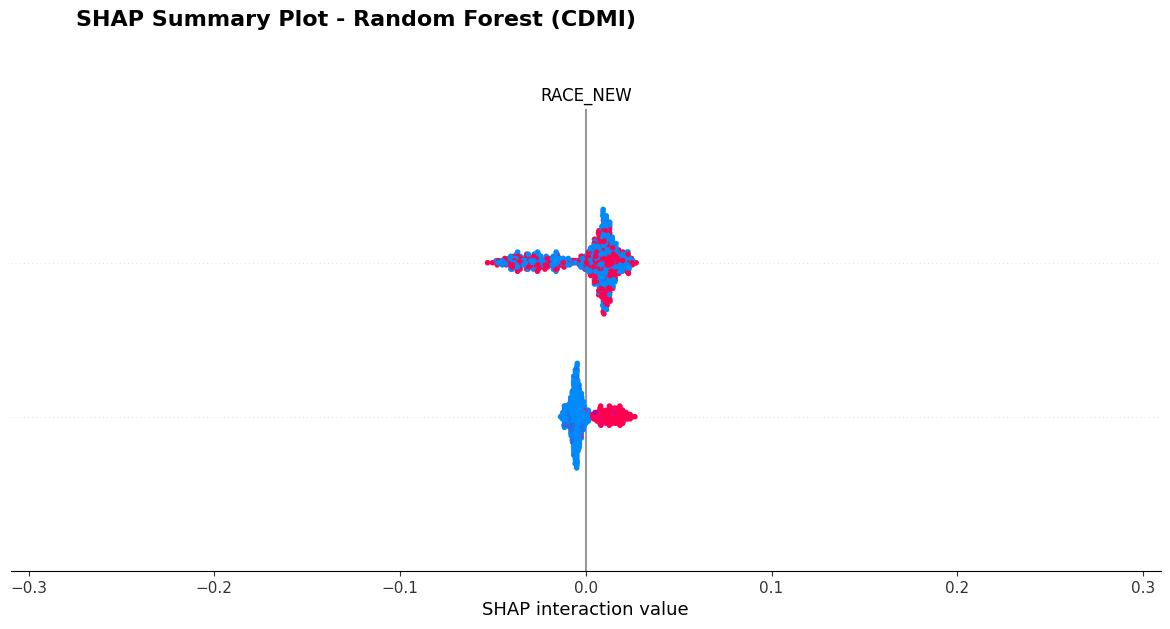

In [ ]:
explainer_RF_CDMI = shap.TreeExplainer(rf_classifier_CDMI)
shap_values_RF_CDMI = explainer_RF_CDMI.shap_values(X_RF_CDMI)
feature_names = X_RF_CDMI.columns

plt.figure(figsize=(18, 6))
shap.summary_plot(shap_values_RF_CDMI, X_RF_CDMI, feature_names=feature_names, plot_size=(2, 0.5), show=False)

plt.suptitle("SHAP Summary Plot - Random Forest (CDMI)", fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.2, bottom=0.2, left=0.2)

plt.show()

The below code creates a LIME (Local Interpretable Model-agnostic Explanations) explanation for a single, randomly selected patient in the myocardial infarction dataset. It explains how the Random Forest model made its prediction for that specific case by showing the contribution of individual features to the predicted probability. The resulting plot visually breaks down which features pushed the prediction toward or away from a myocardial infarction classification.

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

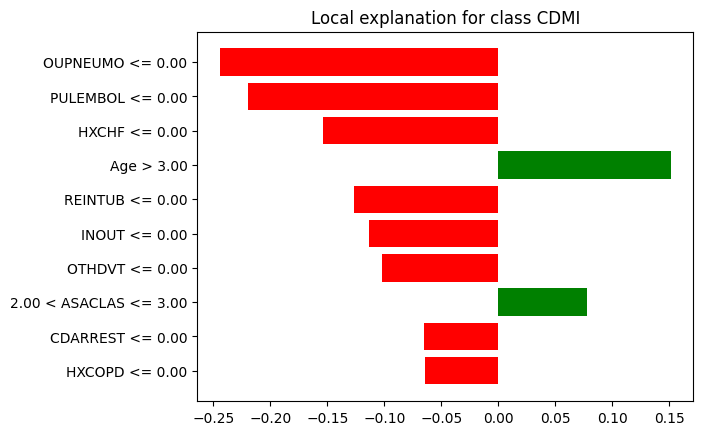

In [ ]:
lime_explainer_RF_CDMI = LimeTabularExplainer(
    training_data=X_RF_CDMI.values,
    feature_names=X_RF_CDMI.columns.tolist(),
    class_names=['No CDMI', 'CDMI'],
    mode='classification'
)

idx_RF_CDMI = np.random.randint(0, X_RF_CDMI.shape[0])
lime_exp_RF_CDMI = lime_explainer_RF_CDMI.explain_instance(
    X_RF_CDMI.iloc[idx_RF_CDMI],
    rf_classifier_CDMI.predict_proba
)

lime_exp_RF_CDMI.show_in_notebook()

fig = lime_exp_RF_CDMI.as_pyplot_figure()
plt.show()

## Combined

The below code builds a combined model by merging two Random Forest classifiers of cardiac arrest and myocardial infarction. It first concatenates the feature and target datasets, ensuring consistent feature names, and then fits a soft-voting ensemble model (VotingClassifier) using both classifiers. The combined model’s performance is evaluated using standard classification metrics (accuracy, F1, recall, precision, and AUC), and the ROC curve is plotted to show its ability to distinguish between classes.

In [ ]:
X_RF_CA_resampled = dfca.drop('CDARREST', axis=1)
y_RF_CA_resampled = dfca['CDARREST']

X_RF_CDMI_resampled = dfcdmi.drop('CDMI', axis=1)
y_RF_CDMI_resampled = dfcdmi['CDMI']

In [ ]:
X_RF_Combined = np.concatenate((X_RF_CA_resampled, X_RF_CDMI_resampled), axis=0)
y_RF_Combined = np.concatenate((y_RF_CA_resampled, y_RF_CDMI_resampled), axis=0)

original_feature_names = X_RF_CA_resampled.columns.tolist()

X_RF_Combined_df = pd.DataFrame(X_RF_Combined, columns=original_feature_names)

voting_classifier_RF_Combined = VotingClassifier(estimators=[
    ('rf_CA', rf_classifier_CA),
    ('rf_CDMI', rf_classifier_CDMI)
], voting='soft')

voting_classifier_RF_Combined.fit(X_RF_Combined, y_RF_Combined)

y_pred_combined_labels = voting_classifier_RF_Combined.predict(X_RF_Combined)

accuracy_combined = accuracy_score(y_RF_Combined, y_pred_combined_labels)
f1_combined = f1_score(y_RF_Combined, y_pred_combined_labels)
recall_combined = recall_score(y_RF_Combined, y_pred_combined_labels)
precision_combined = precision_score(y_RF_Combined, y_pred_combined_labels)

y_pred_combined_prob = voting_classifier_RF_Combined.predict_proba(X_RF_Combined)[:, 1]
fpr_combined, tpr_combined, _ = roc_curve(y_RF_Combined, y_pred_combined_prob)
roc_auc_combined = auc(fpr_combined, tpr_combined)

plt.figure(figsize=(8, 6))
plt.plot(fpr_combined, tpr_combined, color='red', lw=2, label=f'Combined Model (AUC = {roc_auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Combined Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'Combined Model Metrics: ')
print(f'Accuracy: {accuracy_combined:.4f}')
print(f'F1 Score: {f1_combined:.4f}')
print(f'Recall: {recall_combined:.4f}')
print(f'AUC Score: {roc_auc_combined:.4f}')
print(f'Precision: {precision_combined:.4f}')

This code computes SHAP values for the combined dataset with both models, averages them to get a unified interpretation, and then plots a SHAP summary bar chart. This helps identify which features are most influential across both models.

In [ ]:
X_RF_Combined_df = pd.DataFrame(X_RF_Combined, columns=X_RF_CA_resampled.columns)

explainer_RF_CA = shap.TreeExplainer(rf_classifier_CA)
explainer_RF_CDMI = shap.TreeExplainer(rf_classifier_CDMI)

shap_values_RF_CA = explainer_RF_CA.shap_values(X_RF_Combined)
shap_values_RF_CDMI = explainer_RF_CDMI.shap_values(X_RF_Combined)

shap_values_Combined = (shap_values_RF_CA + shap_values_RF_CDMI) / 2

assert shap_values_Combined.shape[1] == X_RF_Combined_df.shape[1], \
    f"Shape mismatch: SHAP values ({shap_values_Combined.shape[1]} features) and data ({X_RF_Combined_df.shape[1]} features)"

shap.summary_plot(shap_values_Combined, X_RF_Combined_df, plot_type="bar", title="SHAP Summary Plot - Combined Model")

This code uses LIME to explain how the combined model made its predictions. It sets up a LimeTabularExplainer with the combined training data and then generates a local explanation for the selected instance by showing how individual features influenced the predicted outcome. The explanation is both displayed as a table and visualized in a bar chart.

In [ ]:
explainer_LIME = LimeTabularExplainer(
    training_data=X_RF_Combined_df.values,
    training_labels=y_RF_Combined,
    mode="classification",
    feature_names=X_RF_Combined_df.columns,
    class_names=["Class 0", "Class 1"],
    discretize_continuous=True
)

instance_to_explain_RF = X_RF_Combined_df.iloc[10]

def predict_combined(X):
    return voting_classifier_RF_Combined.predict_proba(X)

explanation_RF = explainer_LIME.explain_instance(
    instance_to_explain_RF.values,
    predict_combined,
    num_features=10
)

explanation_RF.show_in_notebook(show_table=True, show_all=False)

explanation_RF.as_pyplot_figure()
plt.show()

# XGBoost

## Cardiac Arrest

The below code tunes and evaluates an XGBoost model to predict cardiac arrest using Optuna and 5-fold stratified cross-validation. Optuna searches for the best hyperparameters by maximizing the average AUC-ROC across folds. Once the optimal parameters are found, the model is re-trained to report average performance metrics—accuracy, precision, recall, F1 score, and AUC-ROC. Finally, it plots the ROC curve to visualize the model’s ability to differentiate between patients with and without cardiac arrest.

[I 2025-03-21 16:37:35,879] A new study created in memory with name: no-name-97e8f13e-f86f-41ad-900d-88a065fff4bb
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_by

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:36,932] Trial 0 finished with value: 0.8514177693761816 and parameters: {'max_depth': 7, 'learning_rate': 7.987551593586127e-05, 'n_estimators': 178, 'subsample': 0.8113758389753316, 'colsample_bytree': 0.6345237619849868}. Best is trial 0 with value: 0.8514177693761816.


Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:37,421] Trial 1 finished with value: 0.8650283553875235 and parameters: {'max_depth': 4, 'learning_rate': 2.0115206404314508e-05, 'n_estimators': 126, 'subsample': 0.8873524848343114, 'colsample_bytree': 0.9703936839394}. Best is trial 1 with value: 0.8650283553875235.


Training fold 5
Training fold 1
Training fold 2


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:37,785] Trial 2 finished with value: 0.8521739130434783 and parameters: {'max_depth': 4, 'learning_rate': 0.011288191748507653, 'n_estimators': 70, 'subsample': 0.6304788696707689, 'colsample_bytree': 0.8358625355697868}. Best is trial 1 with value: 0.8650283553875235.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uni

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:37:38,229] Trial 3 finished with value: 0.838563327032136 and parameters: {'max_depth': 4, 'learning_rate': 0.015578360652520462, 'n_estimators': 108, 'subsample': 0.6786926616913456, 'colsample_bytree': 0.7454340836251885}. Best is trial 1 with value: 0.8650283553875235.


Training fold 4
Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:38,820] Trial 4 finished with value: 0.8453686200378071 and parameters: {'max_depth': 10, 'learning_rate': 0.0006476372211618426, 'n_estimators': 175, 'subsample': 0.560373267207464, 'colsample_bytree': 0.7475912225440361}. Best is trial 1 with value: 0.8650283553875235.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:37:39,264] Trial 5 finished with value: 0.854820415879017 and parameters: {'max_depth': 5, 'learning_rate': 2.907117181335125e-05, 'n_estimators': 97, 'subsample': 0.663836554958373, 'colsample_bytree': 0.7033865266783448}. Best is trial 1 with value: 0.8650283553875235.


Training fold 4
Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:39,700] Trial 6 finished with value: 0.8423440453686201 and parameters: {'max_depth': 3, 'learning_rate': 0.05931399495355846, 'n_estimators': 95, 'subsample': 0.955430798350685, 'colsample_bytree': 0.8422699399640012}. Best is trial 1 with value: 0.8650283553875235.


Training fold 5
Training fold 1
Training fold 2


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:40,207] Trial 7 finished with value: 0.8431001890359168 and parameters: {'max_depth': 8, 'learning_rate': 0.0023726327237875277, 'n_estimators': 124, 'subsample': 0.5035627424304747, 'colsample_bytree': 0.78160447226664}. Best is trial 1 with value: 0.8650283553875235.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uni

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:40,714] Trial 8 finished with value: 0.812476370510397 and parameters: {'max_depth': 9, 'learning_rate': 0.05466221220002214, 'n_estimators': 146, 'subsample': 0.5594463604149764, 'colsample_bytree': 0.5122753889670254}. Best is trial 1 with value: 0.8650283553875235.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_unif

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:37:41,111] Trial 9 finished with value: 0.8646502835538753 and parameters: {'max_depth': 3, 'learning_rate': 2.689676869742404e-05, 'n_estimators': 105, 'subsample': 0.7082161959482529, 'colsample_bytree': 0.7881209696469682}. Best is trial 1 with value: 0.8650283553875235.


Training fold 4
Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:41,545] Trial 10 finished with value: 0.8517958412098299 and parameters: {'max_depth': 6, 'learning_rate': 0.00026845412018108584, 'n_estimators': 51, 'subsample': 0.8537752480747275, 'colsample_bytree': 0.9957357343612653}. Best is trial 1 with value: 0.8650283553875235.


Training fold 5
Training fold 1
Training fold 2


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:42,018] Trial 11 finished with value: 0.8629489603024574 and parameters: {'max_depth': 3, 'learning_rate': 1.1598514250343052e-05, 'n_estimators': 143, 'subsample': 0.9896294238394621, 'colsample_bytree': 0.9958227122993557}. Best is trial 1 with value: 0.8650283553875235.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:42,592] Trial 12 finished with value: 0.8536862003780717 and parameters: {'max_depth': 5, 'learning_rate': 8.597448865006623e-05, 'n_estimators': 149, 'subsample': 0.7671188653406124, 'colsample_bytree': 0.8976690965219771}. Best is trial 1 with value: 0.8650283553875235.


Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:43,036] Trial 13 finished with value: 0.8517958412098299 and parameters: {'max_depth': 3, 'learning_rate': 1.4974163679531916e-05, 'n_estimators': 120, 'subsample': 0.8882355930506481, 'colsample_bytree': 0.9029818179889177}. Best is trial 1 with value: 0.8650283553875235.


Training fold 5
Training fold 1
Training fold 2


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:43,490] Trial 14 finished with value: 0.8551984877126655 and parameters: {'max_depth': 5, 'learning_rate': 7.416040143271906e-05, 'n_estimators': 80, 'subsample': 0.7225218970640953, 'colsample_bytree': 0.6372844658112864}. Best is trial 1 with value: 0.8650283553875235.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:37:44,006] Trial 15 finished with value: 0.8680529300567109 and parameters: {'max_depth': 4, 'learning_rate': 0.0002845412655883339, 'n_estimators': 158, 'subsample': 0.8833412902827794, 'colsample_bytree': 0.9170848915509535}. Best is trial 15 with value: 0.8680529300567109.


Training fold 4
Training fold 5


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:44,674] Trial 16 finished with value: 0.8480151228733458 and parameters: {'max_depth': 6, 'learning_rate': 0.001854113527321267, 'n_estimators': 162, 'subsample': 0.9196333231759372, 'colsample_bytree': 0.9326636192465908}. Best is trial 15 with value: 0.8680529300567109.


Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:45,168] Trial 17 finished with value: 0.8570888468809074 and parameters: {'max_depth': 4, 'learning_rate': 0.00029191178694323427, 'n_estimators': 135, 'subsample': 0.8137231812803044, 'colsample_bytree': 0.950749086820452}. Best is trial 15 with value: 0.8680529300567109.


Training fold 5
Training fold 1


<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:37:45,900] Trial 18 finished with value: 0.854820415879017 and parameters: {'max_depth': 7, 'learning_rate': 0.0001789889702199371, 'n_estimators': 195, 'subsample': 0.880247103797518, 'colsample_bytree': 0.8704618831521853}. Best is trial 15 with value: 0.8680529300567109.
<ipython-input-20-5db14eec8152>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-20-5db14eec8152>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-20-5db14eec8152>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:37:46,521] Trial 19 finished with value: 0.8540642722117203 and parameters: {'max_depth': 5, 'learning_rate': 0.000806754169252284, 'n_estimators': 164, 'subsample': 0.8074542644812004, 'colsample_bytree': 0.9587596778425549}. Best is trial 15 with value: 0.8680529300567109.


Training fold 5
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.0002845412655883339, 'n_estimators': 158, 'subsample': 0.8833412902827794, 'colsample_bytree': 0.9170848915509535}
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5

Average accuracy from 5-fold cross-validation: 0.8130
Average precision: 0.9206
Average recall: 0.6870
Average F1 score: 0.7853
Average AUC-ROC: 0.8681


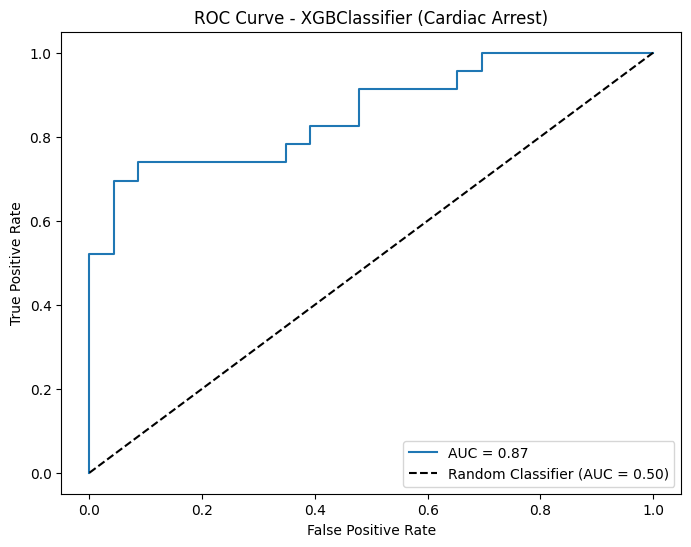

In [ ]:
def objective_XG_CA(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'verbosity': 0
    }
    kf_XG_CA = StratifiedKFold(n_splits=5, shuffle=False)

    fold_accuracies_XG_CA = []
    fold_precisions_XG_CA = []
    fold_recalls_XG_CA = []
    fold_f1_scores_XG_CA = []
    fold_roc_auc_XG_CA = []

    for fold_idx, (train_index, test_index) in enumerate(kf_XG_CA.split(X_RF_CA, y_RF_CA)):
        print(f"Training fold {fold_idx + 1}")

        X_train_XG_CA, X_test_XG_CA = X_RF_CA.iloc[train_index], X_RF_CA.iloc[test_index]
        y_train_XG_CA, y_test_XG_CA = y_RF_CA.iloc[train_index], y_RF_CA.iloc[test_index]

        xgb_classifier_XG_CA = xgb.XGBClassifier(**param)

        xgb_classifier_XG_CA.fit(X_train_XG_CA, y_train_XG_CA)

        y_pred_XG_CA = xgb_classifier_XG_CA.predict(X_test_XG_CA)
        y_pred_prob_XG_CA = xgb_classifier_XG_CA.predict_proba(X_test_XG_CA)[:, 1]  # Probabilities for AUC-ROC

        accuracy_XG_CA = accuracy_score(y_test_XG_CA, y_pred_XG_CA)
        precision_XG_CA = precision_score(y_test_XG_CA, y_pred_XG_CA)
        recall_XG_CA = recall_score(y_test_XG_CA, y_pred_XG_CA)
        f1_XG_CA = f1_score(y_test_XG_CA, y_pred_XG_CA)
        roc_auc_XG_CA = roc_auc_score(y_test_XG_CA, y_pred_prob_XG_CA)

        fold_accuracies_XG_CA.append(accuracy_XG_CA)
        fold_precisions_XG_CA.append(precision_XG_CA)
        fold_recalls_XG_CA.append(recall_XG_CA)
        fold_f1_scores_XG_CA.append(f1_XG_CA)
        fold_roc_auc_XG_CA.append(roc_auc_XG_CA)

    avg_accuracy_XG_CA = np.mean(fold_accuracies_XG_CA)
    avg_precision_XG_CA = np.mean(fold_precisions_XG_CA)
    avg_recall_XG_CA = np.mean(fold_recalls_XG_CA)
    avg_f1_XG_CA = np.mean(fold_f1_scores_XG_CA)
    avg_roc_auc_XG_CA = np.mean(fold_roc_auc_XG_CA)

    return avg_roc_auc_XG_CA

study_XG_CA = optuna.create_study(direction='maximize')
study_XG_CA.optimize(objective_XG_CA, n_trials=20)

print("Best hyperparameters:", study_XG_CA.best_params)

best_params_XG_CA = study_XG_CA.best_params

kf_XG_CA = StratifiedKFold(n_splits=5, shuffle=False)

fold_accuracies_XG_CA = []
fold_precisions_XG_CA = []
fold_recalls_XG_CA = []
fold_f1_scores_XG_CA = []
fold_roc_auc_XG_CA = []

for fold_idx, (train_index, test_index) in enumerate(kf_XG_CA.split(X_RF_CA, y_RF_CA)):
    print(f"Training fold {fold_idx + 1}")

    X_train_XG_CA, X_test_XG_CA = X_RF_CA.iloc[train_index], X_RF_CA.iloc[test_index]
    y_train_XG_CA, y_test_XG_CA = y_RF_CA.iloc[train_index], y_RF_CA.iloc[test_index]

    xgb_classifier_XG_CA = xgb.XGBClassifier(**best_params_XG_CA)

    xgb_classifier_XG_CA.fit(X_train_XG_CA, y_train_XG_CA)

    y_pred_XG_CA = xgb_classifier_XG_CA.predict(X_test_XG_CA)
    y_pred_prob_XG_CA = xgb_classifier_XG_CA.predict_proba(X_test_XG_CA)[:, 1]

    accuracy_XG_CA = accuracy_score(y_test_XG_CA, y_pred_XG_CA)
    precision_XG_CA = precision_score(y_test_XG_CA, y_pred_XG_CA)
    recall_XG_CA = recall_score(y_test_XG_CA, y_pred_XG_CA)
    f1_XG_CA = f1_score(y_test_XG_CA, y_pred_XG_CA)
    roc_auc_XG_CA = roc_auc_score(y_test_XG_CA, y_pred_prob_XG_CA)

    fold_accuracies_XG_CA.append(accuracy_XG_CA)
    fold_precisions_XG_CA.append(precision_XG_CA)
    fold_recalls_XG_CA.append(recall_XG_CA)
    fold_f1_scores_XG_CA.append(f1_XG_CA)
    fold_roc_auc_XG_CA.append(roc_auc_XG_CA)

avg_accuracy_XG_CA = np.mean(fold_accuracies_XG_CA)
avg_precision_XG_CA = np.mean(fold_precisions_XG_CA)
avg_recall_XG_CA = np.mean(fold_recalls_XG_CA)
avg_f1_XG_CA = np.mean(fold_f1_scores_XG_CA)
avg_roc_auc_XG_CA = np.mean(fold_roc_auc_XG_CA)

print(f"\nAverage accuracy from 5-fold cross-validation: {avg_accuracy_XG_CA:.4f}")
print(f"Average precision: {avg_precision_XG_CA:.4f}")
print(f"Average recall: {avg_recall_XG_CA:.4f}")
print(f"Average F1 score: {avg_f1_XG_CA:.4f}")
print(f"Average AUC-ROC: {avg_roc_auc_XG_CA:.4f}")

fpr_XG_CA, tpr_XG_CA, _ = roc_curve(y_test_XG_CA, y_pred_prob_XG_CA)
plt.figure(figsize=(8, 6))
plt.plot(fpr_XG_CA, tpr_XG_CA, label=f'AUC = {avg_roc_auc_XG_CA:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBClassifier (Cardiac Arrest)')
plt.legend(loc='lower right')
plt.show()

This code generates a SHAP summary plot to interpret the XGBoost model trained to predict cardiac arrest. The plot ranks features by their overall importance and shows the direction and magnitude of their impact.

In [ ]:
plt.style.use('petroff10')
plt.rcParams.update({"font.size": 12})

explainer_XG_CA = shap.Explainer(xgb_classifier_XG_CA, X_train_XG_CA)
shap_values_XG_CA = explainer_XG_CA(X_test_XG_CA)

feature_names = X_test_XG_CA.columns

plt.figure(figsize=(18, 6))

shap.summary_plot(shap_values_XG_CA, X_test_XG_CA, feature_names=feature_names, plot_size=(18, 6), show=False)

plt.suptitle("SHAP Summary Plot - XGBClassifier (Cardiac Arrest)",
             fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.0, bottom=0.1, left=0.1)

plt.show()

This code creates a LIME explanation for a randomly selected patient from the test set, showing how the XGBoost model predicted their risk of cardiac arrest. It uses a LimeTabularExplainer to break down the prediction into feature-level contributions, helping to interpret which variables pushed the model toward or away from predicting an arrest.

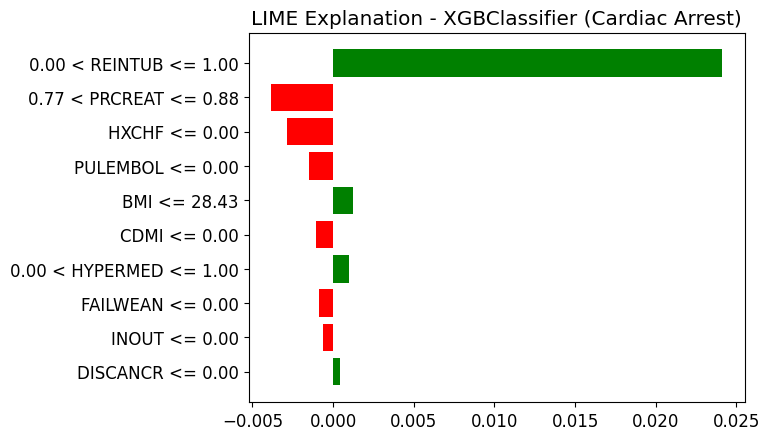

In [ ]:
lime_explainer_XG_CA = LimeTabularExplainer(
    training_data=X_train_XG_CA.values,
    feature_names=X_train_XG_CA.columns.tolist(),
    class_names=['No Arrest', 'Arrest'],
    mode='classification',
    discretize_continuous=True
)

idx_XG_CA = np.random.randint(0, X_test_XG_CA.shape[0])
instance_to_explain = X_test_XG_CA.iloc[idx_XG_CA]

lime_exp_XG_CA = lime_explainer_XG_CA.explain_instance(
    instance_to_explain.values,
    xgb_classifier_XG_CA.predict_proba
)

lime_exp_XG_CA.show_in_notebook()

fig = lime_exp_XG_CA.as_pyplot_figure()
plt.title("LIME Explanation - XGBClassifier (Cardiac Arrest)")
plt.show()

## CDMI

The below code tunes and evaluates an XGBoost model to predict myocardial infarction using Optuna and 5-fold stratified cross-validation. Optuna searches for the best hyperparameters by maximizing the average AUC-ROC across folds. Once the optimal parameters are found, the model is re-trained to report average performance metrics—accuracy, precision, recall, F1 score, and AUC-ROC. Finally, it plots the ROC curve to visualize the model’s ability to differentiate between patients with and without myocardial infarction.

[I 2025-03-21 16:38:08,266] A new study created in memory with name: no-name-705c992c-f2b9-4ae8-bb59-a0609efd1aad
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_by

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:38:08,982] Trial 0 finished with value: 0.7904351470812376 and parameters: {'max_depth': 5, 'learning_rate': 0.019306888233664922, 'n_estimators': 150, 'subsample': 0.872694484139749, 'colsample_bytree': 0.723199603616177}. Best is trial 0 with value: 0.7904351470812376.


Training fold 5
Training fold 1


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:09,736] Trial 1 finished with value: 0.7791739064167047 and parameters: {'max_depth': 5, 'learning_rate': 0.0006227410055762333, 'n_estimators': 141, 'subsample': 0.9250918017105085, 'colsample_bytree': 0.8835720144386254}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:38:10,482] Trial 2 finished with value: 0.7675567748818778 and parameters: {'max_depth': 5, 'learning_rate': 0.0006500194644802445, 'n_estimators': 150, 'subsample': 0.5109532794816425, 'colsample_bytree': 0.7461335261653387}. Best is trial 0 with value: 0.7904351470812376.


Training fold 5
Training fold 1


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:11,473] Trial 3 finished with value: 0.7773473936899863 and parameters: {'max_depth': 7, 'learning_rate': 7.139194691951557e-05, 'n_estimators': 144, 'subsample': 0.9800284034338571, 'colsample_bytree': 0.7799957653388744}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:38:11,920] Trial 4 finished with value: 0.7718007925621094 and parameters: {'max_depth': 4, 'learning_rate': 0.0045806062260114085, 'n_estimators': 83, 'subsample': 0.5985882517738574, 'colsample_bytree': 0.7001437946067548}. Best is trial 0 with value: 0.7904351470812376.


Training fold 4
Training fold 5
Training fold 1


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:15,290] Trial 5 finished with value: 0.767366255144033 and parameters: {'max_depth': 7, 'learning_rate': 0.0002150958926799984, 'n_estimators': 123, 'subsample': 0.7481048389814899, 'colsample_bytree': 0.9128836062639966}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_un

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:38:15,975] Trial 6 finished with value: 0.770987273281512 and parameters: {'max_depth': 5, 'learning_rate': 0.007305799892674691, 'n_estimators': 61, 'subsample': 0.528400330631666, 'colsample_bytree': 0.5324296366543203}. Best is trial 0 with value: 0.7904351470812376.


Training fold 5
Training fold 1
Training fold 2


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 3
Training fold 4


[I 2025-03-21 16:38:16,489] Trial 7 finished with value: 0.7761431184270691 and parameters: {'max_depth': 5, 'learning_rate': 0.018680280627897783, 'n_estimators': 75, 'subsample': 0.6242933430072242, 'colsample_bytree': 0.6739668791314516}. Best is trial 0 with value: 0.7904351470812376.


Training fold 5
Training fold 1


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:17,836] Trial 8 finished with value: 0.761639231824417 and parameters: {'max_depth': 7, 'learning_rate': 2.1746439758994287e-05, 'n_estimators': 196, 'subsample': 0.8614206097577013, 'colsample_bytree': 0.9752911158009685}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:18,363] Trial 9 finished with value: 0.7601627038561195 and parameters: {'max_depth': 7, 'learning_rate': 0.009811473507409726, 'n_estimators': 58, 'subsample': 0.586878209883019, 'colsample_bytree': 0.6336192052621049}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_unif

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:19,425] Trial 10 finished with value: 0.7365523548239599 and parameters: {'max_depth': 10, 'learning_rate': 0.0819395360266728, 'n_estimators': 189, 'subsample': 0.7793957010867901, 'colsample_bytree': 0.5031141698599267}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_un

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:38:19,935] Trial 11 finished with value: 0.7720551364121322 and parameters: {'max_depth': 3, 'learning_rate': 0.0012905068533816126, 'n_estimators': 119, 'subsample': 0.9646517612529898, 'colsample_bytree': 0.8363325163376852}. Best is trial 0 with value: 0.7904351470812376.


Training fold 4
Training fold 5


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:21,293] Trial 12 finished with value: 0.7655921353452217 and parameters: {'max_depth': 9, 'learning_rate': 0.0014743579378049055, 'n_estimators': 165, 'subsample': 0.8770147506430263, 'colsample_bytree': 0.8403410043525439}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:21,806] Trial 13 finished with value: 0.7887821978356958 and parameters: {'max_depth': 3, 'learning_rate': 0.04143404505917284, 'n_estimators': 111, 'subsample': 0.863510134616143, 'colsample_bytree': 0.8878737322829741}. Best is trial 0 with value: 0.7904351470812376.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uni

Training fold 1
Training fold 2
Training fold 3


[I 2025-03-21 16:38:22,283] Trial 14 finished with value: 0.7747088858405731 and parameters: {'max_depth': 3, 'learning_rate': 0.09257277361092411, 'n_estimators': 103, 'subsample': 0.7911073194500586, 'colsample_bytree': 0.777452652899395}. Best is trial 0 with value: 0.7904351470812376.


Training fold 4
Training fold 5


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:22,846] Trial 15 finished with value: 0.7904595336076816 and parameters: {'max_depth': 4, 'learning_rate': 0.030271076138230102, 'n_estimators': 98, 'subsample': 0.8429558787747118, 'colsample_bytree': 0.9814152182709631}. Best is trial 15 with value: 0.7904595336076816.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_u

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:38:23,555] Trial 16 finished with value: 0.7739772900472489 and parameters: {'max_depth': 6, 'learning_rate': 0.025168370775379343, 'n_estimators': 96, 'subsample': 0.7105800205286306, 'colsample_bytree': 0.9868337629027402}. Best is trial 15 with value: 0.7904595336076816.


Training fold 5
Training fold 1


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:24,198] Trial 17 finished with value: 0.7917722146014328 and parameters: {'max_depth': 4, 'learning_rate': 0.004595352937495864, 'n_estimators': 166, 'subsample': 0.8198920676525135, 'colsample_bytree': 0.5885444312011234}. Best is trial 17 with value: 0.7917722146014328.
<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_

Training fold 1
Training fold 2
Training fold 3
Training fold 4


[I 2025-03-21 16:38:24,903] Trial 18 finished with value: 0.7822134583142812 and parameters: {'max_depth': 4, 'learning_rate': 0.0027233403210854324, 'n_estimators': 175, 'subsample': 0.7026592102873765, 'colsample_bytree': 0.5948854518844435}. Best is trial 17 with value: 0.7917722146014328.


Training fold 5
Training fold 1


<ipython-input-23-24f9b3d68c7e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # Log scale for learning_rate
<ipython-input-23-24f9b3d68c7e>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Subsample ratio
<ipython-input-23-24f9b3d68c7e>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # Column sample by tree


Training fold 2
Training fold 3
Training fold 4
Training fold 5


[I 2025-03-21 16:38:25,599] Trial 19 finished with value: 0.7901314586191129 and parameters: {'max_depth': 4, 'learning_rate': 0.00021304899845248597, 'n_estimators': 171, 'subsample': 0.8154815290620735, 'colsample_bytree': 0.5893266064585208}. Best is trial 17 with value: 0.7917722146014328.


Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.004595352937495864, 'n_estimators': 166, 'subsample': 0.8198920676525135, 'colsample_bytree': 0.5885444312011234}
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5

Average accuracy from 5-fold cross-validation: 0.7313
Average precision: 0.7635
Average recall: 0.6633
Average F1 score: 0.7072
Average AUC-ROC: 0.7918


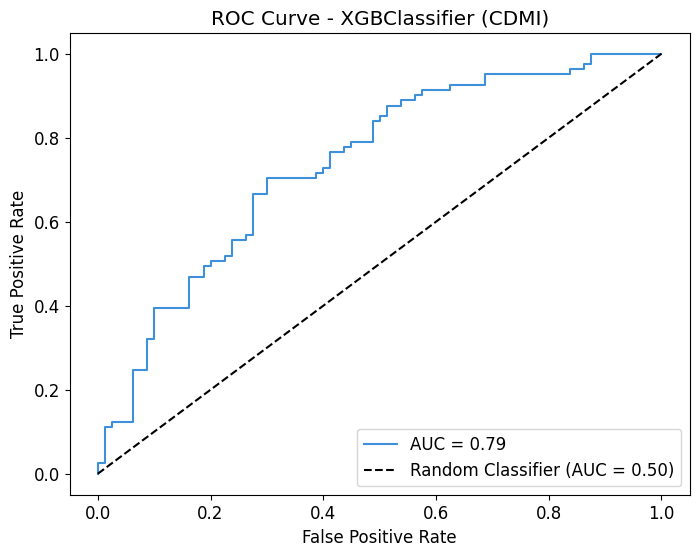

In [ ]:
def objective_XG_CDMI(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'verbosity': 0
    }
    kf_XG_CDMI = StratifiedKFold(n_splits=5, shuffle=False)

    fold_accuracies_XG_CDMI = []
    fold_precisions_XG_CDMI = []
    fold_recalls_XG_CDMI = []
    fold_f1_scores_XG_CDMI = []
    fold_roc_auc_XG_CDMI = []


    for fold_idx, (train_index, test_index) in enumerate(kf_XG_CDMI.split(X_RF_CDMI, y_RF_CDMI)):
        print(f"Training fold {fold_idx + 1}")

        X_train_XG_CDMI, X_test_XG_CDMI = X_RF_CDMI.iloc[train_index], X_RF_CDMI.iloc[test_index]
        y_train_XG_CDMI, y_test_XG_CDMI = y_RF_CDMI.iloc[train_index], y_RF_CDMI.iloc[test_index]

        xgb_classifier_XG_CDMI = xgb.XGBClassifier(**param)

        xgb_classifier_XG_CDMI.fit(X_train_XG_CDMI, y_train_XG_CDMI)

        y_pred_XG_CDMI = xgb_classifier_XG_CDMI.predict(X_test_XG_CDMI)
        y_pred_prob_XG_CDMI = xgb_classifier_XG_CDMI.predict_proba(X_test_XG_CDMI)[:, 1]

        accuracy_XG_CDMI = accuracy_score(y_test_XG_CDMI, y_pred_XG_CDMI)
        precision_XG_CDMI = precision_score(y_test_XG_CDMI, y_pred_XG_CDMI)
        recall_XG_CDMI = recall_score(y_test_XG_CDMI, y_pred_XG_CDMI)
        f1_XG_CDMI = f1_score(y_test_XG_CDMI, y_pred_XG_CDMI)
        roc_auc_XG_CDMI = roc_auc_score(y_test_XG_CDMI, y_pred_prob_XG_CDMI)

        fold_accuracies_XG_CDMI.append(accuracy_XG_CDMI)
        fold_precisions_XG_CDMI.append(precision_XG_CDMI)
        fold_recalls_XG_CDMI.append(recall_XG_CDMI)
        fold_f1_scores_XG_CDMI.append(f1_XG_CDMI)
        fold_roc_auc_XG_CDMI.append(roc_auc_XG_CDMI)

    avg_accuracy_XG_CDMI = np.mean(fold_accuracies_XG_CDMI)
    avg_precision_XG_CDMI = np.mean(fold_precisions_XG_CDMI)
    avg_recall_XG_CDMI = np.mean(fold_recalls_XG_CDMI)
    avg_f1_XG_CDMI = np.mean(fold_f1_scores_XG_CDMI)
    avg_roc_auc_XG_CDMI = np.mean(fold_roc_auc_XG_CDMI)

    return avg_roc_auc_XG_CDMI

study_XG_CDMI = optuna.create_study(direction='maximize')
study_XG_CDMI.optimize(objective_XG_CDMI, n_trials=20)

print("Best hyperparameters:", study_XG_CDMI.best_params)

best_params_XG_CDMI = study_XG_CDMI.best_params

kf_XG_CDMI = StratifiedKFold(n_splits=5, shuffle=False)

fold_accuracies_XG_CDMI = []
fold_precisions_XG_CDMI = []
fold_recalls_XG_CDMI = []
fold_f1_scores_XG_CDMI = []
fold_roc_auc_XG_CDMI = []

for fold_idx, (train_index, test_index) in enumerate(kf_XG_CDMI.split(X_RF_CDMI, y_RF_CDMI)):
    print(f"Training fold {fold_idx + 1}")

    X_train_XG_CDMI, X_test_XG_CDMI = X_RF_CDMI.iloc[train_index], X_RF_CDMI.iloc[test_index]
    y_train_XG_CDMI, y_test_XG_CDMI = y_RF_CDMI.iloc[train_index], y_RF_CDMI.iloc[test_index]

    xgb_classifier_XG_CDMI = xgb.XGBClassifier(**best_params_XG_CDMI)

    xgb_classifier_XG_CDMI.fit(X_train_XG_CDMI, y_train_XG_CDMI)

    y_pred_XG_CDMI = xgb_classifier_XG_CDMI.predict(X_test_XG_CDMI)
    y_pred_prob_XG_CDMI = xgb_classifier_XG_CDMI.predict_proba(X_test_XG_CDMI)[:, 1]

    accuracy_XG_CDMI = accuracy_score(y_test_XG_CDMI, y_pred_XG_CDMI)
    precision_XG_CDMI = precision_score(y_test_XG_CDMI, y_pred_XG_CDMI)
    recall_XG_CDMI = recall_score(y_test_XG_CDMI, y_pred_XG_CDMI)
    f1_XG_CDMI = f1_score(y_test_XG_CDMI, y_pred_XG_CDMI)
    roc_auc_XG_CDMI = roc_auc_score(y_test_XG_CDMI, y_pred_prob_XG_CDMI)

    fold_accuracies_XG_CDMI.append(accuracy_XG_CDMI)
    fold_precisions_XG_CDMI.append(precision_XG_CDMI)
    fold_recalls_XG_CDMI.append(recall_XG_CDMI)
    fold_f1_scores_XG_CDMI.append(f1_XG_CDMI)
    fold_roc_auc_XG_CDMI.append(roc_auc_XG_CDMI)

avg_accuracy_XG_CDMI = np.mean(fold_accuracies_XG_CDMI)
avg_precision_XG_CDMI = np.mean(fold_precisions_XG_CDMI)
avg_recall_XG_CDMI = np.mean(fold_recalls_XG_CDMI)
avg_f1_XG_CDMI = np.mean(fold_f1_scores_XG_CDMI)
avg_roc_auc_XG_CDMI = np.mean(fold_roc_auc_XG_CDMI)

print(f"\nAverage accuracy from 5-fold cross-validation: {avg_accuracy_XG_CDMI:.4f}")
print(f"Average precision: {avg_precision_XG_CDMI:.4f}")
print(f"Average recall: {avg_recall_XG_CDMI:.4f}")
print(f"Average F1 score: {avg_f1_XG_CDMI:.4f}")
print(f"Average AUC-ROC: {avg_roc_auc_XG_CDMI:.4f}")

fpr_XG_CDMI, tpr_XG_CDMI, _ = roc_curve(y_test_XG_CDMI, y_pred_prob_XG_CDMI)
plt.figure(figsize=(8, 6))
plt.plot(fpr_XG_CDMI, tpr_XG_CDMI, label=f'AUC = {avg_roc_auc_XG_CDMI:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBClassifier (CDMI)')
plt.legend(loc='lower right')
plt.show()

This code generates a SHAP summary plot to interpret the XGBoost model trained for predicting myocardial infarction. It uses SHAP values to highlight how each feature influenced model predictions on the test set, ranking them by importance. The plot provides insight into which clinical factors most strongly impact the myocardial infarction outcome.

In [ ]:
plt.style.use('petroff10')
plt.rcParams.update({"font.size": 12})

explainer_XG_CDMI = shap.Explainer(xgb_classifier_XG_CDMI, X_train_XG_CDMI)
shap_values_XG_CDMI = explainer_XG_CDMI(X_test_XG_CDMI)

feature_names = X_test_XG_CDMI.columns

plt.figure(figsize=(18, 6))

shap.summary_plot(shap_values_XG_CDMI, X_test_XG_CDMI, feature_names=feature_names, plot_size=(18, 6), show=False)

plt.suptitle("SHAP Summary Plot - XGBClassifier (CDMI)",
             fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.0, bottom=0.1, left=0.1)

plt.show()

This code uses LIME to explain a single prediction made by the XGBoost model for myocardial infarction. A random instance from the test set is selected, and the LimeTabularExplainer breaks down how each feature contributed to the model's prediction for that case.

In [ ]:
lime_explainer_XG_CDMI = LimeTabularExplainer(
    training_data=X_train_XG_CDMI.values,
    feature_names=X_train_XG_CDMI.columns.tolist(),
    class_names=['No CDMI', 'CDMI'],
    mode='classification',
    discretize_continuous=True
)

idx_XG_CDMI = np.random.randint(0, X_test_XG_CDMI.shape[0])
instance_to_explain = X_test_XG_CDMI.iloc[idx_XG_CDMI]

lime_exp_XG_CDMI = lime_explainer_XG_CDMI.explain_instance(
    instance_to_explain.values,
    xgb_classifier_XG_CDMI.predict_proba
)

lime_exp_XG_CDMI.show_in_notebook()

fig = lime_exp_XG_CDMI.as_pyplot_figure()
plt.title("LIME Explanation - XGBClassifier (CDMI)")
plt.show()

## Combined

The below code resamples the two datasets to create balanced training data. Each dataset is upsampled to 1,000 instances using bootstrapping to ensure equal class representation. The resampled features and targets are then combined into a single dataset, and the feature names are preserved by converting the combined data into a properly labeled DataFrame. Then, an ensemble XGBoost model is built by combining the two optimized classifiers using a soft voting strategy. It trains the combined model on resampled, balanced data and evaluates its performance using accuracy, F1 score, recall, precision, and AUC. Finally, the ROC curve is plotted to visualize how well the ensemble model distinguishes between outcomes.

In [ ]:
X_XG_CA_resampled, y_XG_CA_resampled = resample(dfca.drop(columns=['CDARREST']),
                                                  dfca['CDARREST'],
                                                  replace=True,
                                                  n_samples=1000,
                                                  random_state=42)

X_XG_CDMI_resampled, y_XG_CDMI_resampled = resample(df1_hip_cleaned.drop(columns=['CDMI']),
                                                    df1_hip_cleaned['CDMI'],
                                                    replace=True,
                                                    n_samples=1000,
                                                    random_state=42)

X_XG_Combined = pd.concat([X_XG_CA_resampled, X_XG_CDMI_resampled], axis=0)
y_XG_Combined = pd.concat([y_XG_CA_resampled, y_XG_CDMI_resampled], axis=0)

original_feature_names_XG = X_XG_CA_resampled.columns.tolist()

X_XG_Combined_df = pd.DataFrame(X_XG_Combined, columns=original_feature_names_XG)

In [ ]:
xg_classifier_CA = xgb.XGBClassifier(**best_params_XG_CA)
xg_classifier_CDMI = xgb.XGBClassifier(**best_params_XG_CDMI)

original_feature_names_XG = X_XG_CA_resampled.columns.tolist()

X_XG_Combined_df = pd.DataFrame(X_XG_Combined, columns=original_feature_names_XG)

voting_classifier_XG_Combined = VotingClassifier(estimators=[
    ('xg_CA', xg_classifier_CA),
    ('xg_CDMI', xg_classifier_CDMI)
], voting='soft')

voting_classifier_XG_Combined.fit(X_XG_Combined, y_XG_Combined)

y_pred_combined_labels_XG_Combined = voting_classifier_XG_Combined.predict(X_XG_Combined)

accuracy_combined_XG_Combined = accuracy_score(y_XG_Combined, y_pred_combined_labels_XG_Combined)
f1_combined_XG_Combined = f1_score(y_XG_Combined, y_pred_combined_labels_XG_Combined)
recall_combined_XG_Combined = recall_score(y_XG_Combined, y_pred_combined_labels_XG_Combined)
precision_combined_XG_Combined = precision_score(y_XG_Combined, y_pred_combined_labels_XG_Combined)

y_pred_combined_prob_XG_Combined = voting_classifier_XG_Combined.predict_proba(X_XG_Combined)[:, 1]
fpr_combined_XG_Combined, tpr_combined_XG_Combined, _ = roc_curve(y_XG_Combined, y_pred_combined_prob_XG_Combined)
roc_auc_combined_XG_Combined = auc(fpr_combined_XG_Combined, tpr_combined_XG_Combined)

plt.figure(figsize=(8, 6))
plt.plot(fpr_combined_XG_Combined, tpr_combined_XG_Combined, color='red', lw=2, label=f'Combined Model (AUC = {roc_auc_combined_XG_Combined:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Combined XGBoost Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'Combined Model Metrics: ')
print(f'Accuracy: {accuracy_combined_XG_Combined:.4f}')
print(f'F1 Score: {f1_combined_XG_Combined:.4f}')
print(f'Recall: {recall_combined_XG_Combined:.4f}')
print(f'Precision: {precision_combined_XG_Combined:.4f}')
print(f'AUC Score: {roc_auc_combined_XG_Combined:.4f}')

This code aligns the feature sets from two datasets by adding missing features (filled with zeros) so both models can interpret the same unified dataset. It then calculates SHAP values for each model on the combined data and averages them to create a unified SHAP explanation. The final SHAP summary plot visualizes the overall feature importance across both XGBoost models.

In [ ]:
features_CA = set(X_XG_CA_resampled.columns)
features_CDMI = set(X_XG_CDMI_resampled.columns)

extra_features_CA = features_CA - features_CDMI
extra_features_CDMI = features_CDMI - features_CA

for feature in extra_features_CA:
    X_XG_Combined_df[feature] = 0
for feature in extra_features_CDMI:
    X_XG_Combined_df[feature] = 0

X_XG_Combined_df = X_XG_Combined_df[sorted(X_XG_Combined_df.columns)]

explainer_XG_CA = shap.TreeExplainer(xg_classifier_CA)
explainer_XG_CDMI = shap.TreeExplainer(xg_classifier_CDMI)

shap_values_XG_CA = explainer_XG_CA.shap_values(X_XG_Combined_df)
shap_values_XG_CDMI = explainer_XG_CDMI.shap_values(X_XG_Combined_df)

shap_values_XG_Combined = (shap_values_XG_CA + shap_values_XG_CDMI) / 2

assert shap_values_XG_Combined.shape[1] == X_XG_Combined_df.shape[1], \
    f"Shape mismatch: SHAP values ({shap_values_XG_Combined.shape[1]} features) and data ({X_XG_Combined_df.shape[1]} features)"

shap.summary_plot(shap_values_XG_Combined, X_XG_Combined_df, title="SHAP Summary Plot - Combined XGBoost Model")

# Logistic Regression

## Cardiac Arrest

This code develops a logistic regression model to predict cardiac arrest, using Optuna to fine-tune hyperparameters through 5-fold stratified cross-validation. Then, the final model is trained on the full dataset and evaluated. Key performance metrics (AUC-ROC, accuracy, F1, recall, and precision) are calculated, and the ROC curve is plotted to assess how well the model distinguishes between positive and negative outcomes.

[I 2025-03-21 16:38:44,706] A new study created in memory with name: no-name-8a8db6e1-2061-45d9-af32-c773ced0ab28
<ipython-input-24-bfff21cc934f>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10)  # Regularization strength
[I 2025-03-21 16:38:44,736] Trial 0 finished with value: 0.8843100189035917 and parameters: {'C': 0.0016400111825703545, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8843100189035917.
<ipython-input-24-bfff21cc934f>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10)  # Regularization strength
[I 2025-03-21 16:38:44,780] Trial 1 finished with value: 0.883553

Best hyperparameters for Logistic Regression: {'C': 0.00656105714822114, 'solver': 'liblinear'}


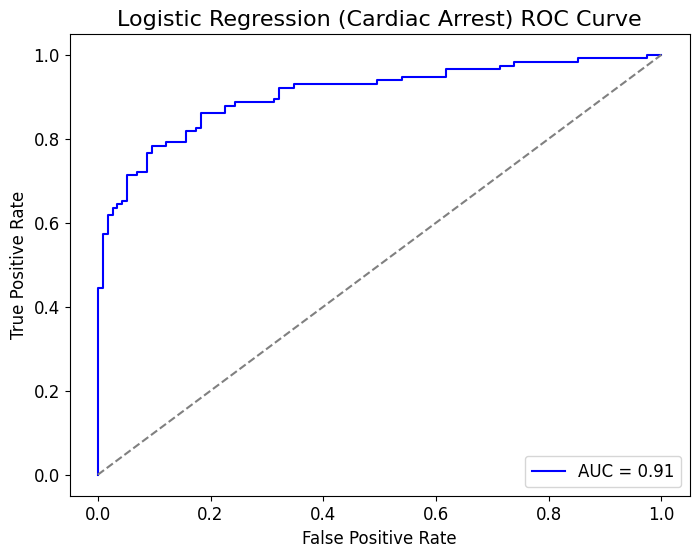

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       115
           1       0.93      0.67      0.78       115

    accuracy                           0.81       230
   macro avg       0.83      0.81      0.80       230
weighted avg       0.83      0.81      0.80       230

AUC-ROC: 0.9063137996219282
Overall Accuracy (Logistic Regression (Cardiac Arrest)): 0.8087
F1 Score (Logistic Regression (Cardiac Arrest)): 0.7778
Recall Score (Logistic Regression (Cardiac Arrest)): 0.6696
Precision Score (Logistic Regression (Cardiac Arrest)): 0.6696


In [ ]:
X_LR_CA = dfca.drop(columns=['CDARREST'])
y_LR_CA = dfca['CDARREST']

scaler_LR_CA = StandardScaler()
X_scaled_LR_CA = scaler_LR_CA.fit_transform(X_LR_CA)

kf_LR_CA = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def lr_ca_objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg'])
    auc_scores = []

    for train_index, test_index in kf_LR_CA.split(X_scaled_LR_CA, y_LR_CA):
        X_train_LR_CA, X_test_LR_CA = X_scaled_LR_CA[train_index], X_scaled_LR_CA[test_index]
        y_train_LR_CA, y_test_LR_CA = y_LR_CA[train_index], y_LR_CA[test_index]

        model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
        model.fit(X_train_LR_CA, y_train_LR_CA)

        y_prob_LR_CA = model.predict_proba(X_test_LR_CA)[:, 1]
        auc_score = roc_auc_score(y_test_LR_CA, y_prob_LR_CA)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

study_LR_CA = optuna.create_study(direction="maximize")
study_LR_CA.optimize(lr_ca_objective, n_trials=50)

best_params_LR_CA = study_LR_CA.best_params
print("Best hyperparameters for Logistic Regression:", best_params_LR_CA)

log_reg_LR_CA = LogisticRegression(**best_params_LR_CA, max_iter=1000, random_state=42)

log_reg_LR_CA.fit(X_scaled_LR_CA, y_LR_CA)

y_pred_LR_CA = log_reg_LR_CA.predict(X_scaled_LR_CA)
y_prob_LR_CA = log_reg_LR_CA.predict_proba(X_scaled_LR_CA)[:, 1]

LR_CA_fpr, LR_CA_tpr, _ = roc_curve(y_LR_CA, y_prob_LR_CA)
roc_auc_LR_CA = roc_auc_score(y_LR_CA, y_prob_LR_CA)

plt.figure(figsize=(8, 6))
plt.plot(LR_CA_fpr, LR_CA_tpr, color='blue', label=f'AUC = {roc_auc_LR_CA:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Logistic Regression (Cardiac Arrest) ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_LR_CA, y_pred_LR_CA))
print("AUC-ROC:", roc_auc_LR_CA)
accuracy_LR_CA = accuracy_score(y_LR_CA, y_pred_LR_CA)
print(f"Overall Accuracy (Logistic Regression (Cardiac Arrest)): {accuracy_LR_CA:.4f}")
f1_LR_CA = f1_score(y_LR_CA, y_pred_LR_CA)
print(f"F1 Score (Logistic Regression (Cardiac Arrest)): {f1_LR_CA:.4f}")
recall_LR_CA = recall_score(y_LR_CA, y_pred_LR_CA)
print(f"Recall Score (Logistic Regression (Cardiac Arrest)): {recall_LR_CA:.4f}")
precision_LR_CA = recall_score(y_LR_CA, y_pred_LR_CA)
print(f"Precision Score (Logistic Regression (Cardiac Arrest)): {precision_LR_CA:.4f}")

This code visualizes the feature contributions of a logistic regression model predicting cardiac arrest using SHAP. After computing SHAP values across the entire dataset, a summary plot is generated to rank features by their impact on the model's predictions.

In [ ]:
explainer_LR_CA = shap.Explainer(log_reg_LR_CA, X_scaled_LR_CA)
shap_values_LR_CA = explainer_LR_CA(X_scaled_LR_CA)

feature_names = X_LR_CA.columns

plt.figure(figsize=(22, 10))

shap.summary_plot(shap_values_LR_CA, X_scaled_LR_CA, feature_names=feature_names, show=False)

plt.suptitle("SHAP Summary Plot - Logistic Regression (Cardiac Arrest)", fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.3, bottom=0.1, left=0.2)

plt.show()

This code uses LIME to explain how the logistic regression model predicted cardiac arrest for a randomly selected patient. It applies LimeTabularExplainer to break down the model's prediction into individual feature contributions, showing which variables pushed the prediction toward or away from cardiac arrest.

In [ ]:
explainer_LR_CA = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled_LR_CA,
    feature_names=X_LR_CA.columns,
    class_names=['No CPR', 'CPR'],
    mode='classification'
)

i = np.random.randint(0, X_scaled_LR_CA.shape[0])
sample_instance = X_scaled_LR_CA[i]

explanation_LR_CA = explainer_LR_CA.explain_instance(
    sample_instance,
    log_reg_LR_CA.predict_proba,
    num_features=10
)

explanation_LR_CA.show_in_notebook()

fig = explanation_LR_CA.as_pyplot_figure()
plt.show()

## CDMI

This code develops a logistic regression model to predict myocardial infarction using Optuna to fine-tune hyperparameters through 5-fold stratified cross-validation. Then, the final model is trained on the full dataset and evaluated. Key performance metrics (AUC-ROC, accuracy, F1, recall, and precision) are calculated, and the ROC curve is plotted to assess how well the model distinguishes between positive and negative outcomes.

[I 2025-03-21 16:39:26,089] A new study created in memory with name: no-name-62a359f4-0341-4559-aa97-d6fda046f517
<ipython-input-25-63be6d18a338>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10)  # Regularization strength
[I 2025-03-21 16:39:26,123] Trial 0 finished with value: 0.8487311385459535 and parameters: {'C': 0.0030446669026693066, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8487311385459535.
<ipython-input-25-63be6d18a338>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10)  # Regularization strength
[I 2025-03-21 16:39:26,154] Trial 1 finished with value: 0.8495297972

Best hyperparameters for Logistic Regression: {'C': 0.06560079998251919, 'solver': 'lbfgs'}


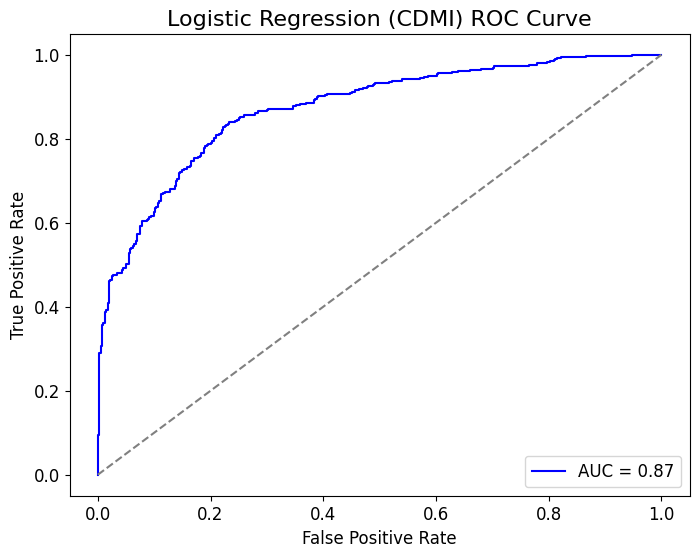

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       404
           1       0.81      0.75      0.78       404

    accuracy                           0.79       808
   macro avg       0.79      0.79      0.79       808
weighted avg       0.79      0.79      0.79       808

AUC-ROC: 0.8715689638270758
Overall Accuracy (Logistic Regression (CDMI)): 0.7884
F1 Score (Logistic Regression (CDMI)): 0.7810
Recall Score (Logistic Regression (CDMI)): 0.7550
Precision Score (Logistic Regression (CDMI)): 0.8090


In [ ]:
X_LR_CDMI = dfcdmi.drop(columns=['CDMI'])
y_LR_CDMI = dfcdmi['CDMI']

scaler_LR_CDMI = StandardScaler()
X_scaled_LR_CDMI = scaler_LR_CDMI.fit_transform(X_LR_CDMI)

kf_LR_CDMI = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def lr_cdmi_objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg'])
    auc_scores = []

    for train_index, test_index in kf_LR_CDMI.split(X_scaled_LR_CDMI, y_LR_CDMI):
        X_train_LR_CDMI, X_test_LR_CDMI = X_scaled_LR_CDMI[train_index], X_scaled_LR_CDMI[test_index]
        y_train_LR_CDMI, y_test_LR_CDMI = y_LR_CDMI[train_index], y_LR_CDMI[test_index]

        model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
        model.fit(X_train_LR_CDMI, y_train_LR_CDMI)

        y_prob_LR_CDMI = model.predict_proba(X_test_LR_CDMI)[:, 1]
        auc_score = roc_auc_score(y_test_LR_CDMI, y_prob_LR_CDMI)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

study_LR_CDMI = optuna.create_study(direction="maximize")
study_LR_CDMI.optimize(lr_cdmi_objective, n_trials=50)

best_params_LR_CDMI = study_LR_CDMI.best_params
print("Best hyperparameters for Logistic Regression:", best_params_LR_CDMI)

log_reg_LR_CDMI = LogisticRegression(**best_params_LR_CDMI, max_iter=1000, random_state=42)

log_reg_LR_CDMI.fit(X_scaled_LR_CDMI, y_LR_CDMI)

y_pred_LR_CDMI = log_reg_LR_CDMI.predict(X_scaled_LR_CDMI)
y_prob_LR_CDMI = log_reg_LR_CDMI.predict_proba(X_scaled_LR_CDMI)[:, 1]

_R_CDMI_fpr, LR_CDMI_tpr, _ = roc_curve(y_LR_CDMI, y_prob_LR_CDMI)
roc_auc_LR_CDMI = roc_auc_score(y_LR_CDMI, y_prob_LR_CDMI)

plt.figure(figsize=(8, 6))
plt.plot(_R_CDMI_fpr, LR_CDMI_tpr, color='blue', label=f'AUC = {roc_auc_LR_CDMI:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Logistic Regression (CDMI) ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_LR_CDMI, y_pred_LR_CDMI))
print("AUC-ROC:", roc_auc_LR_CDMI)
accuracy_LR_CDMI = accuracy_score(y_LR_CDMI, y_pred_LR_CDMI)
print(f"Overall Accuracy (Logistic Regression (CDMI)): {accuracy_LR_CDMI:.4f}")
f1_LR_CDMI = f1_score(y_LR_CDMI, y_pred_LR_CDMI)
print(f"F1 Score (Logistic Regression (CDMI)): {f1_LR_CDMI:.4f}")
recall_LR_CDMI = recall_score(y_LR_CDMI, y_pred_LR_CDMI)
print(f"Recall Score (Logistic Regression (CDMI)): {recall_LR_CDMI:.4f}")
precision_LR_CDMI = precision_score(y_LR_CDMI, y_pred_LR_CDMI)
print(f"Precision Score (Logistic Regression (CDMI)): {precision_LR_CDMI:.4f}")

This code produces a SHAP summary plot to interpret the logistic regression model trained to predict CDMI. It calculates SHAP values to quantify how each feature influenced the model’s output across the entire dataset.

In [ ]:
explainer_LR_CDMI = shap.Explainer(log_reg_LR_CDMI, X_scaled_LR_CDMI)
shap_values_LR_CDMI = explainer_LR_CDMI(X_scaled_LR_CDMI)

feature_names = X_LR_CDMI.columns

plt.figure(figsize=(22, 10))

shap.summary_plot(shap_values_LR_CDMI, X_scaled_LR_CDMI, feature_names=feature_names, show=False)

plt.suptitle("SHAP Summary Plot - Logistic Regression (CDMI)", fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.3, bottom=0.1, left=0.2)

plt.show()

This code uses LIME to interpret a logistic regression model’s prediction for CDMI on a single, randomly selected patient. It explains how individual features contributed to the model's output using the predict_proba function.

In [ ]:
explainer_LR_CDMI = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled_LR_CDMI,
    feature_names=X_LR_CDMI.columns,
    class_names=['No CDMI', 'CDMI'],
    mode='classification'
)

i = np.random.randint(0, X_scaled_LR_CDMI.shape[0])
sample_instance = X_scaled_LR_CDMI[i]

explanation_LR_CDMI = explainer_LR_CDMI.explain_instance(
    sample_instance,
    log_reg_LR_CDMI.predict_proba,
    num_features=10
)
explanation_LR_CDMI.show_in_notebook()

fig = explanation_LR_CDMI.as_pyplot_figure()
plt.show()

## Combined

This code builds a combined logistic regression model using soft voting to integrate predictions from the two models. It merges the feature sets and labels, fits the ensemble model on the full dataset, and evaluates its performance using standard metrics: accuracy, F1 score, recall, precision, and AUC-ROC. The ROC curve is plotted to visualize the model’s ability to distinguish between positive and negative outcomes.

In [ ]:
X_LR_CA_resampled = dfca.drop('CDARREST', axis=1)
y_LR_CA_resampled = dfca['CDARREST']

X_LR_CDMI_resampled = df1_hip_cleaned.drop('CDMI', axis=1)
y_LR_CDMI_resampled = df1_hip_cleaned['CDMI']

X_LR_Combined = np.concatenate((X_LR_CA_resampled, X_LR_CDMI_resampled), axis=0)
y_LR_Combined = np.concatenate((y_LR_CA_resampled, y_LR_CDMI_resampled), axis=0)

original_feature_names = X_LR_CA_resampled.columns.tolist()

X_LR_Combined_df = pd.DataFrame(X_LR_Combined, columns=original_feature_names)

log_reg_CA = LogisticRegression(max_iter=1000)
log_reg_CDMI = LogisticRegression(max_iter=1000)

voting_classifier_LR_Combined = VotingClassifier(estimators=[
    ('log_reg_CA', log_reg_CA),
    ('log_reg_CDMI', log_reg_CDMI)
], voting='soft')

voting_classifier_LR_Combined.fit(X_LR_Combined, y_LR_Combined)

y_pred_combined_labels = voting_classifier_LR_Combined.predict(X_LR_Combined)

accuracy_combined = accuracy_score(y_LR_Combined, y_pred_combined_labels)
f1_combined = f1_score(y_LR_Combined, y_pred_combined_labels)
recall_combined = recall_score(y_LR_Combined, y_pred_combined_labels)
precision_combined = precision_score(y_LR_Combined, y_pred_combined_labels)

y_pred_combined_prob = voting_classifier_LR_Combined.predict_proba(X_LR_Combined)[:, 1]
fpr_combined, tpr_combined, _ = roc_curve(y_LR_Combined, y_pred_combined_prob)
roc_auc_combined = auc(fpr_combined, tpr_combined)

plt.figure(figsize=(8, 6))
plt.plot(fpr_combined, tpr_combined, color='red', lw=2, label=f'Combined Model (AUC = {roc_auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Combined Logistic Regression Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'Combined Model Metrics: ')
print(f'Accuracy: {accuracy_combined:.4f}')
print(f'F1 Score: {f1_combined:.4f}')
print(f'Recall: {recall_combined:.4f}')
print(f'AUC Score: {roc_auc_combined:.4f}')
print(f'Precision: {precision_combined:.4f}')

In [ ]:
log_reg_CA.fit(X_LR_CA_resampled, y_RF_CA_resampled)
log_reg_CDMI.fit(X_LR_CDMI_resampled, y_RF_CDMI_resampled)

This code generates a combined SHAP summary plot for the two logistic regression models. Each model is trained separately, and SHAP values are calculated across a unified dataset. The SHAP values from both models are then averaged to reflect the joint influence of features in the ensemble setting. The final summary plot visualizes which variables consistently impact predictions across both models.

In [ ]:
log_reg_CA.fit(X_LR_CA_resampled, y_RF_CA_resampled)
log_reg_CDMI.fit(X_LR_CDMI_resampled, y_RF_CDMI_resampled)

X_LR_Combined_df = pd.DataFrame(X_LR_Combined, columns=X_LR_CA_resampled.columns)

explainer_LR_CA = shap.LinearExplainer(log_reg_CA, X_LR_Combined_df)
explainer_LR_CDMI = shap.LinearExplainer(log_reg_CDMI, X_LR_Combined_df)

shap_values_LR_CA = explainer_LR_CA.shap_values(X_LR_Combined_df)
shap_values_LR_CDMI = explainer_LR_CDMI.shap_values(X_LR_Combined_df)

shap_values_Combined = (shap_values_LR_CA + shap_values_LR_CDMI) / 2

assert shap_values_Combined.shape[1] == X_LR_Combined_df.shape[1], \
    f"Shape mismatch: SHAP values ({shap_values_Combined.shape[1]} features) and data ({X_LR_Combined_df.shape[1]} features)"

shap.summary_plot(shap_values_Combined, X_LR_Combined_df, plot_type="dot")

plt.suptitle('SHAP Summary Plot - Combined Logistic Regression Model', fontsize=16)
plt.show()

In [ ]:
log_reg_CA.fit(X_LR_CA_resampled, y_RF_CA_resampled)
log_reg_CDMI.fit(X_LR_CDMI_resampled, y_RF_CDMI_resampled)

This code generates a LIME explanation for a combined logistic regression model that predicts cardiac arrest or myocardial infarction. It includes several assertion checks to ensure that the data and feature dimensions align correctly, preventing errors during explanation. Once validated, LIME is used to explain a single instance (the first row of the combined dataset), showing how individual features contributed to the model’s prediction.

In [ ]:
assert X_LR_Combined.shape[1] == len(X_LR_Combined_df.columns), \
    f"Feature count mismatch: Data has {X_LR_Combined.shape[1]} features, but {len(X_LR_Combined_df.columns)} feature names were provided."

assert all([col in X_LR_Combined_df.columns for col in X_LR_Combined_df.columns.tolist()]), \
    f"Mismatch in feature names: Some feature names are missing in the DataFrame."

assert X_LR_Combined.shape[1] == X_LR_Combined_df.shape[1], \
    f"Feature count mismatch: Model data has {X_LR_Combined.shape[1]} features, but DataFrame has {X_LR_Combined_df.shape[1]} features."

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_LR_Combined,
    training_labels=y_LR_Combined,
    feature_names=X_LR_Combined_df.columns.tolist(),
    class_names=['No Arrest', 'Arrest'],
    mode='classification',
    discretize_continuous=True
)

instance_to_explain = X_LR_Combined[0]

assert instance_to_explain.shape[0] == X_LR_Combined.shape[1], \
    f"Instance shape mismatch: Instance has {instance_to_explain.shape[0]} features, but expected {X_LR_Combined.shape[1]}."

prediction_to_explain = voting_classifier_LR_Combined.predict_proba([instance_to_explain])

assert prediction_to_explain.shape[1] == 2, \
    f"Prediction shape mismatch: Expected 2 classes, but got {prediction_to_explain.shape[1]} classes."

explanation = explainer.explain_instance(instance_to_explain, voting_classifier_LR_Combined.predict_proba, num_features=10)

explanation.show_in_notebook(show_table=True, show_all=False)

fig = explanation.as_pyplot_figure()
plt.show()

# Neural Network

## Cardiac Arrest

The below code performs 5-fold cross-validation to evaluate a neural network model (model_NN_CA) designed to predict cardiac arrest. It trains and tests the model on different subsets of the data (X_NN_CA, y_NN_CA) while calculating key performance metrics for each fold: AUC-ROC, accuracy, precision, recall, and F1 score. The function returns the averaged ROC curve data and mean evaluation metrics, making it useful for both visual and quantitative model performance comparison.

In [ ]:
def kfold_cross_validation_NN_CA(X_NN_CA, y_NN_CA, model_NN_CA, n_splits=5):
    kf_NN_CA = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    roc_auc_scores_NN_CA = []
    accuracy_scores_NN_CA = []
    precision_scores_NN_CA = []
    recall_scores_NN_CA = []
    f1_scores_NN_CA = []

    fpr_list_NN_CA, tpr_list_NN_CA = [], []

    for train_index, test_index in kf_NN_CA.split(X_NN_CA):
        X_train_NN_CA, X_test_NN_CA = X_NN_CA[train_index], X_NN_CA[test_index]
        y_train_NN_CA, y_test_NN_CA = y_NN_CA[train_index], y_NN_CA[test_index]

        model_NN_CA.fit(X_train_NN_CA, y_train_NN_CA, epochs=20, batch_size=32, class_weight=class_weight_NN_CA, verbose=0)
        y_prob_NN_CA = model_NN_CA.predict(X_test_NN_CA).flatten()
        y_pred_NN_CA = (y_prob_NN_CA > 0.5).astype(int)

        fpr_NN_CA, tpr_NN_CA, _ = roc_curve(y_test_NN_CA, y_prob_NN_CA)
        roc_auc_NN_CA = roc_auc_score(y_test_NN_CA, y_prob_NN_CA)

        fpr_list_NN_CA.append(fpr_NN_CA)
        tpr_list_NN_CA.append(tpr_NN_CA)
        roc_auc_scores_NN_CA.append(roc_auc_NN_CA)

        accuracy_NN_CA = accuracy_score(y_test_NN_CA, y_pred_NN_CA)
        precision_NN_CA = precision_score(y_test_NN_CA, y_pred_NN_CA)
        recall_NN_CA = recall_score(y_test_NN_CA, y_pred_NN_CA)
        f1_NN_CA = f1_score(y_test_NN_CA, y_pred_NN_CA)

        accuracy_scores_NN_CA.append(accuracy_NN_CA)
        precision_scores_NN_CA.append(precision_NN_CA)
        recall_scores_NN_CA.append(recall_NN_CA)
        f1_scores_NN_CA.append(f1_NN_CA)

        print(f"Fold ROC AUC: {roc_auc_NN_CA:.4f} | Accuracy: {accuracy_NN_CA:.4f} | Precision: {precision_NN_CA:.4f} | Recall: {recall_NN_CA:.4f} | F1: {f1_NN_CA:.4f}")

    mean_fpr_NN_CA = np.linspace(0, 1, 100)
    mean_tpr_NN_CA = np.zeros_like(mean_fpr_NN_CA)

    for fpr_NN_CA, tpr_NN_CA in zip(fpr_list_NN_CA, tpr_list_NN_CA):
        mean_tpr_NN_CA += np.interp(mean_fpr_NN_CA, fpr_NN_CA, tpr_NN_CA)

    mean_tpr_NN_CA /= len(fpr_list_NN_CA)
    mean_roc_auc_NN_CA = np.mean(roc_auc_scores_NN_CA)

    mean_accuracy_NN_CA = np.mean(accuracy_scores_NN_CA)
    mean_precision_NN_CA = np.mean(precision_scores_NN_CA)
    mean_recall_NN_CA = np.mean(recall_scores_NN_CA)
    mean_f1_NN_CA = np.mean(f1_scores_NN_CA)

    print(f"\nAverage metrics across all folds:")
    print(f"Average ROC AUC: {mean_roc_auc_NN_CA:.4f}")
    print(f"Average Accuracy: {mean_accuracy_NN_CA:.4f}")
    print(f"Average Precision: {mean_precision_NN_CA:.4f}")
    print(f"Average Recall: {mean_recall_NN_CA:.4f}")
    print(f"Average F1 Score: {mean_f1_NN_CA:.4f}")

    return mean_fpr_NN_CA, mean_tpr_NN_CA, mean_roc_auc_NN_CA, mean_accuracy_NN_CA, mean_precision_NN_CA, mean_recall_NN_CA, mean_f1_NN_CA

[I 2025-03-22 13:39:03,444] A new study created in memory with name: no-name-9ac438d9-af67-4b24-9def-60997dcda321
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:06,665] Trial 0 finished with value: 0.9934971644612477 and parameters: {'units_1': 112, 'dropout_1': 0.2524349496191412, 'units_2': 108, 'learning_rate': 0.005386294661936159}. Best is trial 0 with value: 0.9934971644612477.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:39:09,045] Trial 1 finished with value: 0.924007561436673 and parameters: {'units_1': 67, 'dropout_1': 0.4016451277562748, 'units_2': 106, 'learning_rate': 0.0008824722961294187}. Best is trial 0 with value: 0.9934971644612477.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:39:11,600] Trial 2 finished with value: 0.9532703213610586 and parameters: {'units_1': 239, 'dropout_1': 0.3931339969767593, 'units_2': 71, 'learning_rate': 0.0010640354762629606}. Best is trial 0 with value: 0.9934971644612477.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 13:39:14,291] Trial 3 finished with value: 0.9998487712665407 and parameters: {'units_1': 251, 'dropout_1': 0.24260299169061875, 'units_2': 125, 'learning_rate': 0.0057050920772638465}. Best is trial 3 with value: 0.9998487712665407.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 13:39:17,838] Trial 4 finished with value: 0.6155765595463139 and parameters: {'units_1': 216, 'dropout_1': 0.3203976005443068, 'units_2': 45, 'learning_rate': 2.4004758913137505e-05}. Best is trial 3 with value: 0.9998487712665407.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:20,493] Trial 5 finished with value: 0.8919470699432893 and parameters: {'units_1': 146, 'dropout_1': 0.4919307213138441, 'units_2': 103, 'learning_rate': 0.00022597276149407636}. Best is trial 3 with value: 0.9998487712665407.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:23,004] Trial 6 finished with value: 0.9689224952741021 and parameters: {'units_1': 79, 'dropout_1': 0.41179512473558355, 'units_2': 91, 'learning_rate': 0.002623503637898832}. Best is trial 3 with value: 0.9998487712665407.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:39:25,368] Trial 7 finished with value: 0.9819281663516068 and parameters: {'units_1': 164, 'dropout_1': 0.20575044517540345, 'units_2': 72, 'learning_rate': 0.002209214880636632}. Best is trial 3 with value: 0.9998487712665407.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 13:39:27,695] Trial 8 finished with value: 0.9968241965973536 and parameters: {'units_1': 208, 'dropout_1': 0.38109152002891855, 'units_2': 36, 'learning_rate': 0.006285122011963718}. Best is trial 3 with value: 0.9998487712665407.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 13:39:31,159] Trial 9 finished with value: 0.9999243856332704 and parameters: {'units_1': 171, 'dropout_1': 0.29003318865414796, 'units_2': 114, 'learning_rate': 0.009261993524832892}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:33,880] Trial 10 finished with value: 0.8363705103969754 and parameters: {'units_1': 169, 'dropout_1': 0.33413035753764897, 'units_2': 128, 'learning_rate': 0.00013070259102493107}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:39:36,269] Trial 11 finished with value: 0.9990926275992438 and parameters: {'units_1': 247, 'dropout_1': 0.2725832083825094, 'units_2': 128, 'learning_rate': 0.007925398379967967}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:39:38,710] Trial 12 finished with value: 0.9981852551984878 and parameters: {'units_1': 196, 'dropout_1': 0.2746868681417929, 'units_2': 120, 'learning_rate': 0.009209949495564793}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:41,719] Trial 13 finished with value: 0.7765595463137996 and parameters: {'units_1': 131, 'dropout_1': 0.21552292613050608, 'units_2': 90, 'learning_rate': 6.088549093173333e-05}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 13:39:45,609] Trial 14 finished with value: 0.9457844990548204 and parameters: {'units_1': 187, 'dropout_1': 0.30840941573310793, 'units_2': 115, 'learning_rate': 0.0006472689073754428}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:39:47,939] Trial 15 finished with value: 0.9820037807183365 and parameters: {'units_1': 108, 'dropout_1': 0.2440129149645203, 'units_2': 94, 'learning_rate': 0.0022824685088860814}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:50,358] Trial 16 finished with value: 0.4400756143667297 and parameters: {'units_1': 229, 'dropout_1': 0.285525382581543, 'units_2': 56, 'learning_rate': 1.3178108804608853e-05}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:52,794] Trial 17 finished with value: 0.9954631379962193 and parameters: {'units_1': 252, 'dropout_1': 0.35797362400045907, 'units_2': 117, 'learning_rate': 0.0031204204386941652}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:39:55,240] Trial 18 finished with value: 0.9333837429111531 and parameters: {'units_1': 184, 'dropout_1': 0.23613545489751722, 'units_2': 81, 'learning_rate': 0.00043851360636515857}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 13:39:59,070] Trial 19 finished with value: 0.9779962192816635 and parameters: {'units_1': 220, 'dropout_1': 0.2868782094841088, 'units_2': 103, 'learning_rate': 0.0016907672363148695}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:01,618] Trial 20 finished with value: 0.9779962192816635 and parameters: {'units_1': 143, 'dropout_1': 0.4747860414735, 'units_2': 121, 'learning_rate': 0.003746217027701139}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:04,820] Trial 21 finished with value: 0.9990170132325141 and parameters: {'units_1': 255, 'dropout_1': 0.2649453952161968, 'units_2': 128, 'learning_rate': 0.008486770005721862}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:07,291] Trial 22 finished with value: 0.9996219281663515 and parameters: {'units_1': 241, 'dropout_1': 0.2949345750818733, 'units_2': 128, 'learning_rate': 0.009786172279408464}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 13:40:10,003] Trial 23 finished with value: 0.9917580340264651 and parameters: {'units_1': 230, 'dropout_1': 0.30245509445697916, 'units_2': 111, 'learning_rate': 0.004687187167981724}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:13,370] Trial 24 finished with value: 0.9719470699432893 and parameters: {'units_1': 204, 'dropout_1': 0.341897270333217, 'units_2': 120, 'learning_rate': 0.001241560724276211}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 13:40:16,634] Trial 25 finished with value: 0.9990170132325142 and parameters: {'units_1': 235, 'dropout_1': 0.2234525667587064, 'units_2': 98, 'learning_rate': 0.004523364941507383}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-03-22 13:40:19,565] Trial 26 finished with value: 0.9990926275992439 and parameters: {'units_1': 172, 'dropout_1': 0.30122086341988746, 'units_2': 112, 'learning_rate': 0.009174218495621904}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:40:21,954] Trial 27 finished with value: 0.9948582230623818 and parameters: {'units_1': 215, 'dropout_1': 0.359834488592572, 'units_2': 123, 'learning_rate': 0.0037939773890632313}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 13:40:25,429] Trial 28 finished with value: 0.9702835538752362 and parameters: {'units_1': 101, 'dropout_1': 0.2540559254839983, 'units_2': 79, 'learning_rate': 0.0015918574497030553}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 13:40:28,093] Trial 29 finished with value: 0.9990170132325142 and parameters: {'units_1': 188, 'dropout_1': 0.2365426665217117, 'units_2': 109, 'learning_rate': 0.005810159011432594}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:40:30,993] Trial 30 finished with value: 0.7916068052930055 and parameters: {'units_1': 133, 'dropout_1': 0.32307106422700715, 'units_2': 112, 'learning_rate': 8.909373139366964e-05}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:33,517] Trial 31 finished with value: 0.9989413988657846 and parameters: {'units_1': 175, 'dropout_1': 0.3023378580921748, 'units_2': 113, 'learning_rate': 0.0094891833603558}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:36,060] Trial 32 finished with value: 0.9991682419659735 and parameters: {'units_1': 157, 'dropout_1': 0.29445393962046723, 'units_2': 100, 'learning_rate': 0.006135615015276814}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:39,778] Trial 33 finished with value: 0.9990170132325142 and parameters: {'units_1': 148, 'dropout_1': 0.2579204109363022, 'units_2': 99, 'learning_rate': 0.005673374629008898}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:42,231] Trial 34 finished with value: 0.9448771266540642 and parameters: {'units_1': 120, 'dropout_1': 0.2822734660992327, 'units_2': 123, 'learning_rate': 0.0008676844293704565}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:44,606] Trial 35 finished with value: 0.9999243856332704 and parameters: {'units_1': 155, 'dropout_1': 0.2228717768480611, 'units_2': 107, 'learning_rate': 0.005679170235572294}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:47,008] Trial 36 finished with value: 0.9933459357277883 and parameters: {'units_1': 241, 'dropout_1': 0.22514499750160336, 'units_2': 106, 'learning_rate': 0.00311705469157128}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:40:49,467] Trial 37 finished with value: 0.8982986767485822 and parameters: {'units_1': 79, 'dropout_1': 0.20637618315307227, 'units_2': 117, 'learning_rate': 0.0003274392698043371}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 13:40:53,864] Trial 38 finished with value: 0.976257088846881 and parameters: {'units_1': 155, 'dropout_1': 0.25070866601624514, 'units_2': 107, 'learning_rate': 0.0018084765332520777}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:40:56,407] Trial 39 finished with value: 0.9998487712665406 and parameters: {'units_1': 220, 'dropout_1': 0.20005577085047646, 'units_2': 123, 'learning_rate': 0.004493093280280576}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:40:58,954] Trial 40 finished with value: 0.969905482041588 and parameters: {'units_1': 222, 'dropout_1': 0.20152164701155256, 'units_2': 85, 'learning_rate': 0.001131442431867427}. Best is trial 9 with value: 0.9999243856332704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:41:01,498] Trial 41 finished with value: 1.0 and parameters: {'units_1': 244, 'dropout_1': 0.223589507534832, 'units_2': 122, 'learning_rate': 0.006072872083115476}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 13:41:04,777] Trial 42 finished with value: 0.999546313799622 and parameters: {'units_1': 247, 'dropout_1': 0.2294593402663896, 'units_2': 123, 'learning_rate': 0.0028981582521768667}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:41:07,512] Trial 43 finished with value: 0.9997731568998109 and parameters: {'units_1': 204, 'dropout_1': 0.2190551761053918, 'units_2': 53, 'learning_rate': 0.006891487902879457}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:41:09,888] Trial 44 finished with value: 0.9994706994328922 and parameters: {'units_1': 256, 'dropout_1': 0.20134122551718023, 'units_2': 119, 'learning_rate': 0.004432801384121562}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:41:12,336] Trial 45 finished with value: 0.9956143667296786 and parameters: {'units_1': 227, 'dropout_1': 0.24550131438076406, 'units_2': 124, 'learning_rate': 0.006265304914491685}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:41:14,784] Trial 46 finished with value: 0.9894896030245748 and parameters: {'units_1': 212, 'dropout_1': 0.2654600613202276, 'units_2': 116, 'learning_rate': 0.002385203849646872}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 13:41:18,250] Trial 47 finished with value: 0.9066162570888469 and parameters: {'units_1': 194, 'dropout_1': 0.2136442232664043, 'units_2': 106, 'learning_rate': 0.0001824392363757138}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 13:41:20,959] Trial 48 finished with value: 0.9911531190926276 and parameters: {'units_1': 241, 'dropout_1': 0.41543874178768614, 'units_2': 67, 'learning_rate': 0.0035146719050205117}. Best is trial 41 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 13:41:23,366] Trial 49 finished with value: 0.9519848771266541 and parameters: {'units_1': 166, 'dropout_1': 0.2367223028353595, 'units_2': 125, 'learning_rate': 0.0007024135590146445}. Best is trial 41 with value: 1.0.


Running K-fold Cross-validation...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Fold ROC AUC: 0.8038 | Accuracy: 0.7609 | Precision: 0.8000 | Recall: 0.7692 | F1: 0.7843
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold ROC AUC: 0.9654 | Accuracy: 0.8913 | Precision: 0.8947 | Recall: 0.8500 | F1: 0.8718
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold ROC AUC: 0.9886 | Accuracy: 0.9783 | Precision: 1.0000 | Recall: 0.9583 | F1: 0.9787
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Fold ROC AUC: 0.9962 | Accuracy: 0.9783 | Precision: 1.0000 | Recall: 0.9524 | F1: 0.9756
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold ROC AUC: 1.0000 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

Average metrics across all folds:
Average ROC AUC: 0.9508
Average Accuracy: 0.9217
Average Precision: 0.9389
Average Recall: 0.9060
Average F1 Score: 0.9221
Average ROC AUC: 0.9508
Average Accuracy: 0.9217
Average Precision: 0.9389
Average Recall: 0.9060
Average F1 Score: 0.9221


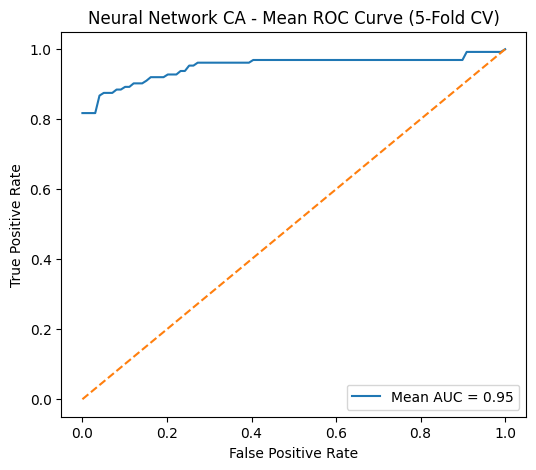

In [ ]:
# Assume 'CA' is the target variable for your model, replace with the actual column name if necessary
X_NN_CA = dfca.drop('CDARREST', axis=1).values  # Features (excluding the target column 'CA')
y_NN_CA = dfca['CDARREST'].values  # Target variable (e.g., 'CA')

# Scale the features
scaler_NN_CA = StandardScaler()
X_scaled_NN_CA = scaler_NN_CA.fit_transform(X_NN_CA)  # Fit and transform on the entire dataset

# Define the model creation function
def build_nn_CA_Model(input_dim, best_params_NN_CA):
    model_NN_CA = Sequential()
    model_NN_CA.add(Dense(best_params_NN_CA['units_1'], input_dim=input_dim, activation='relu'))
    model_NN_CA.add(Dropout(best_params_NN_CA['dropout_1']))
    model_NN_CA.add(Dense(best_params_NN_CA['units_2'], activation='relu'))
    model_NN_CA.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    model_NN_CA.compile(optimizer=Adam(learning_rate=best_params_NN_CA['learning_rate']),
                          loss='binary_crossentropy', metrics=['accuracy'])
    return model_NN_CA

# Define the objective function for hyperparameter optimization
def optimize_nn_CA_with_optuna():
    def objective(trial):
        units_1 = trial.suggest_int('units_1', 64, 256)
        dropout_1 = trial.suggest_float('dropout_1', 0.2, 0.5)
        units_2 = trial.suggest_int('units_2', 32, 128)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

        model_NN_CA = build_nn_CA_Model(X_scaled_NN_CA.shape[1],
                                            {'units_1': units_1, 'dropout_1': dropout_1, 'units_2': units_2, 'learning_rate': learning_rate})

        model_NN_CA.fit(X_scaled_NN_CA, y_NN_CA, epochs=10, batch_size=32, verbose=0)
        y_prob_NN_CA = model_NN_CA.predict(X_scaled_NN_CA).flatten()
        roc_auc_NN_CA = roc_auc_score(y_NN_CA, y_prob_NN_CA)

        return roc_auc_NN_CA

    study_NN_CA = optuna.create_study(direction='maximize')
    study_NN_CA.optimize(objective, n_trials=50)

    return study_NN_CA.best_params

# K-fold Cross-validation with additional metrics (Random Split)
def kfold_cross_validation_NN_CA(X_NN_CA, y_NN_CA, model_NN_CA, n_splits=5):
    kf_NN_CA = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Random split (shuffle=True)

    roc_auc_scores_NN_CA = []
    accuracy_scores_NN_CA = []
    precision_scores_NN_CA = []
    recall_scores_NN_CA = []
    f1_scores_NN_CA = []

    fpr_list_NN_CA, tpr_list_NN_CA = [], []

    for train_index, test_index in kf_NN_CA.split(X_NN_CA):
        X_train_NN_CA, X_test_NN_CA = X_NN_CA[train_index], X_NN_CA[test_index]
        y_train_NN_CA, y_test_NN_CA = y_NN_CA[train_index], y_NN_CA[test_index]

        model_NN_CA.fit(X_train_NN_CA, y_train_NN_CA, epochs=20, batch_size=32, verbose=0)
        y_prob_NN_CA = model_NN_CA.predict(X_test_NN_CA).flatten()
        y_pred_NN_CA = (y_prob_NN_CA > 0.5).astype(int)

        # Collect ROC metrics
        fpr_NN_CA, tpr_NN_CA, _ = roc_curve(y_test_NN_CA, y_prob_NN_CA)
        roc_auc_NN_CA = roc_auc_score(y_test_NN_CA, y_prob_NN_CA)

        fpr_list_NN_CA.append(fpr_NN_CA)
        tpr_list_NN_CA.append(tpr_NN_CA)
        roc_auc_scores_NN_CA.append(roc_auc_NN_CA)

        # Evaluation metrics
        accuracy_NN_CA = accuracy_score(y_test_NN_CA, y_pred_NN_CA)
        precision_NN_CA = precision_score(y_test_NN_CA, y_pred_NN_CA)
        recall_NN_CA = recall_score(y_test_NN_CA, y_pred_NN_CA)
        f1_NN_CA = f1_score(y_test_NN_CA, y_pred_NN_CA)

        accuracy_scores_NN_CA.append(accuracy_NN_CA)
        precision_scores_NN_CA.append(precision_NN_CA)
        recall_scores_NN_CA.append(recall_NN_CA)
        f1_scores_NN_CA.append(f1_NN_CA)

        print(f"Fold ROC AUC: {roc_auc_NN_CA:.4f} | Accuracy: {accuracy_NN_CA:.4f} | Precision: {precision_NN_CA:.4f} | Recall: {recall_NN_CA:.4f} | F1: {f1_NN_CA:.4f}")

    # Average ROC metrics across folds
    mean_fpr_NN_CA = np.linspace(0, 1, 100)  # Same length for all folds
    mean_tpr_NN_CA = np.zeros_like(mean_fpr_NN_CA)

    # Interpolating ROC curves
    for fpr_NN_CA, tpr_NN_CA in zip(fpr_list_NN_CA, tpr_list_NN_CA):
        mean_tpr_NN_CA += np.interp(mean_fpr_NN_CA, fpr_NN_CA, tpr_NN_CA)

    mean_tpr_NN_CA /= len(fpr_list_NN_CA)
    mean_roc_auc_NN_CA = np.mean(roc_auc_scores_NN_CA)

    # Calculate the mean of other metrics
    mean_accuracy_NN_CA = np.mean(accuracy_scores_NN_CA)
    mean_precision_NN_CA = np.mean(precision_scores_NN_CA)
    mean_recall_NN_CA = np.mean(recall_scores_NN_CA)
    mean_f1_NN_CA = np.mean(f1_scores_NN_CA)

    print(f"\nAverage metrics across all folds:")
    print(f"Average ROC AUC: {mean_roc_auc_NN_CA:.4f}")
    print(f"Average Accuracy: {mean_accuracy_NN_CA:.4f}")
    print(f"Average Precision: {mean_precision_NN_CA:.4f}")
    print(f"Average Recall: {mean_recall_NN_CA:.4f}")
    print(f"Average F1 Score: {mean_f1_NN_CA:.4f}")

    return mean_fpr_NN_CA, mean_tpr_NN_CA, mean_roc_auc_NN_CA, mean_accuracy_NN_CA, mean_precision_NN_CA, mean_recall_NN_CA, mean_f1_NN_CA


# Running the Final Model with K-fold Cross-validation
def run_nn_CA_Model():
    best_params_NN_CA = optimize_nn_CA_with_optuna()
    model_NN_CA = build_nn_CA_Model(X_scaled_NN_CA.shape[1], best_params_NN_CA)

    print("Running K-fold Cross-validation...\n")
    mean_fpr_NN_CA, mean_tpr_NN_CA, mean_roc_auc_NN_CA, mean_accuracy_NN_CA, mean_precision_NN_CA, mean_recall_NN_CA, mean_f1_NN_CA = kfold_cross_validation_NN_CA(X_scaled_NN_CA, y_NN_CA, model_NN_CA, n_splits=5)

    # Print the results
    print(f"Average ROC AUC: {mean_roc_auc_NN_CA:.4f}")
    print(f"Average Accuracy: {mean_accuracy_NN_CA:.4f}")
    print(f"Average Precision: {mean_precision_NN_CA:.4f}")
    print(f"Average Recall: {mean_recall_NN_CA:.4f}")
    print(f"Average F1 Score: {mean_f1_NN_CA:.4f}")

    # Plot the mean ROC curve across folds
    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr_NN_CA, mean_tpr_NN_CA, label=f'Mean AUC = {mean_roc_auc_NN_CA:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network CA - Mean ROC Curve (5-Fold CV)')
    plt.legend()
    plt.show()

    return model_NN_CA, mean_fpr_NN_CA, mean_tpr_NN_CA, mean_roc_auc_NN_CA


if __name__ == "__main__":
    model_NN_CA, mean_fpr_NN_CA, mean_tpr_NN_CA, mean_roc_auc_NN_CA = run_nn_CA_Model()

The below code uses SHAP to interpret a trained neural network model that predicts cardiac arrest. It applies KernelExplainer, which is model-agnostic, to estimate how each feature contributes to the model's predictions. A SHAP summary plot is generated to visualize the most influential features for the positive class (cardiac arrest).

In [ ]:
def explain_with_shap(model_NN_CA, X_train_NN_CA):
    """
    Explains the neural network model using SHAP and generates summary plots.
    :param model_NN_CA: The trained neural network model.
    :param X_train_NN_CA: The training data used to explain the model.
    :return: SHAP values for the model.
    """
    explainer = shap.KernelExplainer(model_NN_CA.predict, X_train_NN_CA)
    shap_values = explainer.shap_values(X_train_NN_CA)

    shap.summary_plot(shap_values[1], X_train_NN_CA)

    return shap_values

def run_shap_for_nn_model(model_NN_CA, X_train_NN_CA):
    """
    This function calls SHAP for explaining the model.
    :param model_NN_CA: The trained neural network model.
    :param X_train_NN_CA: The training data used for SHAP explanation.
    :return: SHAP values.
    """
    print("Generating SHAP values for the trained model...")
    shap_values = explain_with_shap(model_NN_CA, X_train_NN_CA)
    return shap_values

shap_values = run_shap_for_nn_model(model_NN_CA, X_scaled_NN_CA)

In [ ]:
print(X_scaled_NN_CA.shape)

(230, 27)


This code uses LIME to interpret predictions from a neural network trained to detect cardiac arrest. It explains a single test instance by showing how the model's prediction is influenced by each feature. A wrapper function reshapes the model's output into class probabilities, and LIME visualizes the top contributing features.

In [ ]:
def explain_with_lime_NN_CA(model, X_train, X_test, feature_names):
    explainer = LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=['No Cardiac Arrest', 'Cardiac Arrest'],
        mode='classification'
    )

    instance = X_test[0].reshape(1, -1)

    def predict_fn(X):
        return np.hstack([1 - model.predict(X), model.predict(X)])

    explanation = explainer.explain_instance(instance.flatten(), predict_fn, num_features=10)

    explanation.show_in_notebook(show_table=True, show_all=False)

    fig = explanation.as_pyplot_figure()
    plt.show()

explain_with_lime_NN_CA(model_NN_CA, X_scaled_NN_CA, X_scaled_NN_CA, feature_names_NN_CA)

## CDMI

This function performs 5-fold cross-validation to evaluate a neural network model trained to predict myocardial infarction. For each fold, it trains the model, makes predictions, and computes performance metrics including AUC-ROC, accuracy, precision, recall, and F1 score. It also collects and averages ROC curves to visualize performance across splits. The final output includes the mean ROC curve data and averaged metrics.

In [ ]:
def kfold_cross_validation_NN_CDMI(X_NN_CDMI, y_NN_CDMI, model_NN_CDMI, n_splits=5):
    kf_NN_CDMI = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    roc_auc_scores_NN_CDMI = []
    accuracy_scores_NN_CDMI = []
    precision_scores_NN_CDMI = []
    recall_scores_NN_CDMI = []
    f1_scores_NN_CDMI = []

    fpr_list_NN_CDMI, tpr_list_NN_CDMI = [], []

    for train_index, test_index in kf_NN_CDMI.split(X_NN_CDMI):
        X_train_NN_CDMI, X_test_NN_CDMI = X_NN_CDMI[train_index], X_NN_CDMI[test_index]
        y_train_NN_CDMI, y_test_NN_CDMI = y_NN_CDMI[train_index], y_NN_CDMI[test_index]

        model_NN_CDMI.fit(X_train_NN_CDMI, y_train_NN_CDMI, epochs=20, batch_size=32, class_weight=class_weight_NN_CDMI, verbose=0)
        y_prob_NN_CDMI = model_NN_CDMI.predict(X_test_NN_CDMI).flatten()
        y_pred_NN_CDMI = (y_prob_NN_CDMI > 0.5).astype(int)

        fpr_NN_CDMI, tpr_NN_CDMI, _ = roc_curve(y_test_NN_CDMI, y_prob_NN_CDMI)
        roc_auc_NN_CDMI = roc_auc_score(y_test_NN_CDMI, y_prob_NN_CDMI)

        fpr_list_NN_CDMI.append(fpr_NN_CDMI)
        tpr_list_NN_CDMI.append(tpr_NN_CDMI)
        roc_auc_scores_NN_CDMI.append(roc_auc_NN_CDMI)

        accuracy_NN_CDMI = accuracy_score(y_test_NN_CDMI, y_pred_NN_CDMI)
        precision_NN_CDMI = precision_score(y_test_NN_CDMI, y_pred_NN_CDMI)
        recall_NN_CDMI = recall_score(y_test_NN_CDMI, y_pred_NN_CDMI)
        f1_NN_CDMI = f1_score(y_test_NN_CDMI, y_pred_NN_CDMI)

        accuracy_scores_NN_CDMI.append(accuracy_NN_CDMI)
        precision_scores_NN_CDMI.append(precision_NN_CDMI)
        recall_scores_NN_CDMI.append(recall_NN_CDMI)
        f1_scores_NN_CDMI.append(f1_NN_CDMI)

        print(f"Fold ROC AUC: {roc_auc_NN_CDMI:.4f} | Accuracy: {accuracy_NN_CDMI:.4f} | Precision: {precision_NN_CDMI:.4f} | Recall: {recall_NN_CDMI:.4f} | F1: {f1_NN_CDMI:.4f}")

    mean_fpr_NN_CDMI = np.linspace(0, 1, 100)
    mean_tpr_NN_CDMI = np.zeros_like(mean_fpr_NN_CDMI)

    for fpr_NN_CDMI, tpr_NN_CDMI in zip(fpr_list_NN_CDMI, tpr_list_NN_CDMI):
        mean_tpr_NN_CDMI += np.interp(mean_fpr_NN_CDMI, fpr_NN_CDMI, tpr_NN_CDMI)

    mean_tpr_NN_CDMI /= len(fpr_list_NN_CDMI)
    mean_roc_auc_NN_CDMI = np.mean(roc_auc_scores_NN_CDMI)

    mean_accuracy_NN_CDMI = np.mean(accuracy_scores_NN_CDMI)
    mean_precision_NN_CDMI = np.mean(precision_scores_NN_CDMI)
    mean_recall_NN_CDMI = np.mean(recall_scores_NN_CDMI)
    mean_f1_NN_CDMI = np.mean(f1_scores_NN_CDMI)

    print(f"\nAverage metrics across all folds:")
    print(f"Average ROC AUC: {mean_roc_auc_NN_CDMI:.4f}")
    print(f"Average Accuracy: {mean_accuracy_NN_CDMI:.4f}")
    print(f"Average Precision: {mean_precision_NN_CDMI:.4f}")
    print(f"Average Recall: {mean_recall_NN_CDMI:.4f}")
    print(f"Average F1 Score: {mean_f1_NN_CDMI:.4f}")

    return mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, mean_roc_auc_NN_CDMI, mean_accuracy_NN_CDMI, mean_precision_NN_CDMI, mean_recall_NN_CDMI, mean_f1_NN_CDMI

In [ ]:
X_NN_CDMI = df1_hip_cleaned.drop('CDMI', axis=1).values
y_NN_CDMI = df1_hip_cleaned['CDMI'].values

scaler_NN_CDMI = StandardScaler()
X_scaled_NN_CDMI = scaler_NN_CDMI.fit_transform(X_NN_CDMI)

def build_nn_CDMI_Model(input_dim, best_params_NN_CDMI):
    model_NN_CDMI = Sequential()
    model_NN_CDMI.add(Dense(best_params_NN_CDMI['units_1'], input_dim=input_dim, activation='relu'))
    model_NN_CDMI.add(Dropout(best_params_NN_CDMI['dropout_1']))
    model_NN_CDMI.add(Dense(best_params_NN_CDMI['units_2'], activation='relu'))
    model_NN_CDMI.add(Dense(1, activation='sigmoid'))

    model_NN_CDMI.compile(optimizer=Adam(learning_rate=best_params_NN_CDMI['learning_rate']),
                          loss='binary_crossentropy', metrics=['accuracy'])
    return model_NN_CDMI

def optimize_nn_CDMI_with_optuna():
    def objective(trial):
        units_1 = trial.suggest_int('units_1', 64, 256)
        dropout_1 = trial.suggest_float('dropout_1', 0.2, 0.5)
        units_2 = trial.suggest_int('units_2', 32, 128)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

        model_NN_CDMI = build_nn_CDMI_Model(X_scaled_NN_CDMI.shape[1],
                                            {'units_1': units_1, 'dropout_1': dropout_1, 'units_2': units_2, 'learning_rate': learning_rate})

        model_NN_CDMI.fit(X_scaled_NN_CDMI, y_NN_CDMI, epochs=10, batch_size=32, verbose=0)
        y_prob_NN_CDMI = model_NN_CDMI.predict(X_scaled_NN_CDMI).flatten()
        roc_auc_NN_CDMI = roc_auc_score(y_NN_CDMI, y_prob_NN_CDMI)

        return roc_auc_NN_CDMI

    study_NN_CDMI = optuna.create_study(direction='maximize')
    study_NN_CDMI.optimize(objective, n_trials=50)

    return study_NN_CDMI.best_params

def kfold_cross_validation_NN_CDMI(X_NN_CDMI, y_NN_CDMI, model_NN_CDMI, n_splits=5):
    kf_NN_CDMI = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Random split (shuffle=True)

    roc_auc_scores_NN_CDMI = []
    accuracy_scores_NN_CDMI = []
    precision_scores_NN_CDMI = []
    recall_scores_NN_CDMI = []
    f1_scores_NN_CDMI = []

    fpr_list_NN_CDMI, tpr_list_NN_CDMI = [], []

    for train_index, test_index in kf_NN_CDMI.split(X_NN_CDMI):
        X_train_NN_CDMI, X_test_NN_CDMI = X_NN_CDMI[train_index], X_NN_CDMI[test_index]
        y_train_NN_CDMI, y_test_NN_CDMI = y_NN_CDMI[train_index], y_NN_CDMI[test_index]

        model_NN_CDMI.fit(X_train_NN_CDMI, y_train_NN_CDMI, epochs=20, batch_size=32, verbose=0)
        y_prob_NN_CDMI = model_NN_CDMI.predict(X_test_NN_CDMI).flatten()
        y_pred_NN_CDMI = (y_prob_NN_CDMI > 0.5).astype(int)

        fpr_NN_CDMI, tpr_NN_CDMI, _ = roc_curve(y_test_NN_CDMI, y_prob_NN_CDMI)
        roc_auc_NN_CDMI = roc_auc_score(y_test_NN_CDMI, y_prob_NN_CDMI)

        fpr_list_NN_CDMI.append(fpr_NN_CDMI)
        tpr_list_NN_CDMI.append(tpr_NN_CDMI)
        roc_auc_scores_NN_CDMI.append(roc_auc_NN_CDMI)

        accuracy_NN_CDMI = accuracy_score(y_test_NN_CDMI, y_pred_NN_CDMI)
        precision_NN_CDMI = precision_score(y_test_NN_CDMI, y_pred_NN_CDMI)
        recall_NN_CDMI = recall_score(y_test_NN_CDMI, y_pred_NN_CDMI)
        f1_NN_CDMI = f1_score(y_test_NN_CDMI, y_pred_NN_CDMI)

        accuracy_scores_NN_CDMI.append(accuracy_NN_CDMI)
        precision_scores_NN_CDMI.append(precision_NN_CDMI)
        recall_scores_NN_CDMI.append(recall_NN_CDMI)
        f1_scores_NN_CDMI.append(f1_NN_CDMI)

        print(f"Fold ROC AUC: {roc_auc_NN_CDMI:.4f} | Accuracy: {accuracy_NN_CDMI:.4f} | Precision: {precision_NN_CDMI:.4f} | Recall: {recall_NN_CDMI:.4f} | F1: {f1_NN_CDMI:.4f}")

    mean_fpr_NN_CDMI = np.linspace(0, 1, 100)
    mean_tpr_NN_CDMI = np.zeros_like(mean_fpr_NN_CDMI)

    for fpr_NN_CDMI, tpr_NN_CDMI in zip(fpr_list_NN_CDMI, tpr_list_NN_CDMI):
        mean_tpr_NN_CDMI += np.interp(mean_fpr_NN_CDMI, fpr_NN_CDMI, tpr_NN_CDMI)

    mean_tpr_NN_CDMI /= len(fpr_list_NN_CDMI)
    mean_roc_auc_NN_CDMI = np.mean(roc_auc_scores_NN_CDMI)

    mean_accuracy_NN_CDMI = np.mean(accuracy_scores_NN_CDMI)
    mean_precision_NN_CDMI = np.mean(precision_scores_NN_CDMI)
    mean_recall_NN_CDMI = np.mean(recall_scores_NN_CDMI)
    mean_f1_NN_CDMI = np.mean(f1_scores_NN_CDMI)

    print(f"\nAverage metrics across all folds:")
    print(f"Average ROC AUC: {mean_roc_auc_NN_CDMI:.4f}")
    print(f"Average Accuracy: {mean_accuracy_NN_CDMI:.4f}")
    print(f"Average Precision: {mean_precision_NN_CDMI:.4f}")
    print(f"Average Recall: {mean_recall_NN_CDMI:.4f}")
    print(f"Average F1 Score: {mean_f1_NN_CDMI:.4f}")

    return mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, mean_roc_auc_NN_CDMI, mean_accuracy_NN_CDMI, mean_precision_NN_CDMI, mean_recall_NN_CDMI, mean_f1_NN_CDMI


def run_nn_CDMI_Model():
    best_params_NN_CDMI = optimize_nn_CDMI_with_optuna()
    model_NN_CDMI = build_nn_CDMI_Model(X_scaled_NN_CDMI.shape[1], best_params_NN_CDMI)

    print("Running K-fold Cross-validation...\n")
    mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, mean_roc_auc_NN_CDMI, mean_accuracy_NN_CDMI, mean_precision_NN_CDMI, mean_recall_NN_CDMI, mean_f1_NN_CDMI = kfold_cross_validation_NN_CDMI(X_scaled_NN_CDMI, y_NN_CDMI, model_NN_CDMI, n_splits=5)

    print(f"Average ROC AUC: {mean_roc_auc_NN_CDMI:.4f}")
    print(f"Average Accuracy: {mean_accuracy_NN_CDMI:.4f}")
    print(f"Average Precision: {mean_precision_NN_CDMI:.4f}")
    print(f"Average Recall: {mean_recall_NN_CDMI:.4f}")
    print(f"Average F1 Score: {mean_f1_NN_CDMI:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, label=f'Mean AUC = {mean_roc_auc_NN_CDMI:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network CDMI - Mean ROC Curve (5-Fold CV)')
    plt.legend()
    plt.show()

    return model_NN_CDMI, mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, mean_roc_auc_NN_CDMI


if __name__ == "__main__":
    model_NN_CDMI, mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, mean_roc_auc_NN_CDMI = run_nn_CDMI_Model()


This code generates a SHAP summary plot to interpret the neural network model predicting myocardial infarction. Using DeepExplainer, it computes SHAP values to quantify how each input feature impacts the model's output. The summary plot ranks features by importance and shows the direction and magnitude of their effects.

In [ ]:
plt.style.use('petroff10')
plt.rcParams.update({"font.size": 12})

explainer_NN_CDMI = shap.DeepExplainer(model_NN_CDMI, X_scaled_NN_CDMI)

shap_values_NN_CDMI = explainer_NN_CDMI.shap_values(X_scaled_NN_CDMI)

feature_names_NN_CDMI = X_scaled_NN_CDMI.columns

plt.figure(figsize=(18, 6))

shap.summary_plot(shap_values_NN_CDMI, X_scaled_NN_CDMI, feature_names=feature_names_NN_CDMI, plot_size=(18, 6), show=False)

plt.suptitle("SHAP Summary Plot - Neural Network Model (CDMI)",
             fontsize=16, fontweight="bold", y=1.05)

plt.subplots_adjust(top=0.90, right=1.0, bottom=0.1, left=0.1)

plt.show()

This code uses LIME to interpret a neural network model trained to predict myocardial infarction. It selects a random patient case from the test data and explains the model’s prediction by highlighting the top ten features that influenced the decision. A custom prediction function reshapes the model’s output into class probabilities.

In [ ]:
def explain_with_lime_NN_CDMI(model, X_train, X_test, feature_names):
    explainer = LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=['No CDMI', 'CDMI'],
        mode='classification'
    )

    instance = X_test[0].reshape(1, -1)

    def predict_fn(X):
        return np.hstack([1 - model.predict(X), model.predict(X)])

    explanation = explainer.explain_instance(instance.flatten(), predict_fn, num_features=10)

    explanation.show_in_notebook(show_table=True, show_all=False)

    fig = explanation.as_pyplot_figure()
    plt.show()

explain_with_lime_NN_CDMI(model_NN_CDMI, X_scaled_NN_CDMI, X_scaled_NN_CDMI, feature_names_NN_CDMI)

## Combined

This code builds a combined neural network model using features shared between the two datasets. A neural network is trained on the unified dataset to predict both outcomes. Finally, it evaluates the model’s performance using accuracy, F1 score, recall, and precision—providing a single, interpretable view of how well the combined model generalizes across both conditions.

In [ ]:
common_columns_NN_Combined = dfcdmi.columns.intersection(dfca.columns)

dfcdmi = dfcdmi.reindex(columns=common_columns_NN_Combined, fill_value=np.nan)
dfca = dfca.reindex(columns=common_columns_NN_Combined, fill_value=np.nan)

X_NN_Combined = pd.concat([dfcdmi.drop(columns=['CDMI']), dfca.drop(columns=['CDARREST'])], axis=0)

y_NN_Combined = pd.concat([dfcdmi['CDMI'], dfca['CDARREST']], axis=0)

imputer_NN_Combined = SimpleImputer(strategy='mean')
X_NN_Combined_imputed = imputer_NN_Combined.fit_transform(X_NN_Combined)

print(f"Shape of imputed combined features: {X_NN_Combined_imputed.shape}")

scaler_NN_Combined = StandardScaler()
X_NN_Combined_scaled = scaler_NN_Combined.fit_transform(X_NN_Combined_imputed)

print(f"Shape of scaled combined features: {X_NN_Combined_scaled.shape}")

nn_classifier_NN_Combined = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

nn_classifier_NN_Combined.fit(X_NN_Combined_scaled, y_NN_Combined)

y_pred_combined_NN_Combined = nn_classifier_NN_Combined.predict(X_NN_Combined_scaled)

accuracy_combined_NN_Combined = accuracy_score(y_NN_Combined, y_pred_combined_NN_Combined)
f1_combined_NN_Combined = f1_score(y_NN_Combined, y_pred_combined_NN_Combined)
recall_combined_NN_Combined = recall_score(y_NN_Combined, y_pred_combined_NN_Combined)
precision_combined_NN_Combined = precision_score(y_NN_Combined, y_pred_combined_NN_Combined)

print(f'Combined NN Model Metrics: ')
print(f'Accuracy: {accuracy_combined_NN_Combined:.4f}')
print(f'F1 Score: {f1_combined_NN_Combined:.4f}')
print(f'Recall: {recall_combined_NN_Combined:.4f}')
print(f'Precision: {precision_combined_NN_Combined:.4f}')

Shape of imputed combined features: (1038, 28)
Shape of scaled combined features: (1038, 28)
Combined NN Model Metrics: 
Accuracy: 0.9374
F1 Score: 0.9357
Recall: 0.9114
Precision: 0.9614


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Combined Model Metrics: 
Accuracy: 0.9374
F1 Score: 0.9357
Recall: 0.9114
Precision: 0.9614


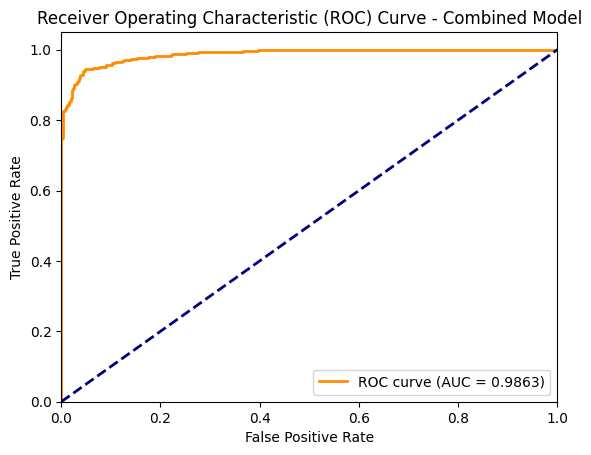

In [ ]:
common_columns = dfcdmi.columns.intersection(dfca.columns)

dfcdmi = dfcdmi.reindex(columns=common_columns, fill_value=np.nan)
dfca = dfca.reindex(columns=common_columns, fill_value=np.nan)

X_NN_Combined_NN = pd.concat([dfcdmi.drop(columns=['CDMI']), dfca.drop(columns=['CDARREST'])], axis=0)

y_NN_Combined_NN = pd.concat([dfcdmi['CDMI'], dfca['CDARREST']], axis=0)

imputer_NN_Combined = SimpleImputer(strategy='mean')
X_NN_Combined_imputed_NN = imputer_NN_Combined.fit_transform(X_NN_Combined_NN)

scaler_NN_Combined = StandardScaler()
X_NN_Combined_scaled_NN = scaler_NN_Combined.fit_transform(X_NN_Combined_imputed_NN)

nn_classifier_NN_Combined = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

nn_classifier_NN_Combined.fit(X_NN_Combined_scaled_NN, y_NN_Combined_NN)

y_pred_combined_NN_Combined = nn_classifier_NN_Combined.predict(X_NN_Combined_scaled_NN)

accuracy_combined_NN_Combined = accuracy_score(y_NN_Combined_NN, y_pred_combined_NN_Combined)
f1_combined_NN_Combined = f1_score(y_NN_Combined_NN, y_pred_combined_NN_Combined)
recall_combined_NN_Combined = recall_score(y_NN_Combined_NN, y_pred_combined_NN_Combined)
precision_combined_NN_Combined = precision_score(y_NN_Combined_NN, y_pred_combined_NN_Combined)

print(f'Combined Model Metrics: ')
print(f'Accuracy: {accuracy_combined_NN_Combined:.4f}')
print(f'F1 Score: {f1_combined_NN_Combined:.4f}')
print(f'Recall: {recall_combined_NN_Combined:.4f}')
print(f'Precision: {precision_combined_NN_Combined:.4f}')

y_pred_prob_combined_NN_Combined = nn_classifier_NN_Combined.predict_proba(X_NN_Combined_scaled_NN)[:, 1]
fpr, tpr, thresholds = roc_curve(y_NN_Combined_NN, y_pred_prob_combined_NN_Combined)
roc_auc_combined_NN_Combined = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_combined_NN_Combined:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Combined Model')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(roc_auc_combined_NN_Combined)

0.9863306120782147


This code uses LIME to interpret a neural network model trained on a combined dataset of CDMI and cardiac arrest outcomes. It explains a specific instance by highlighting the top ten features that most influenced the model's prediction. The explanation is presented both in an interactive notebook format and as a bar chart.

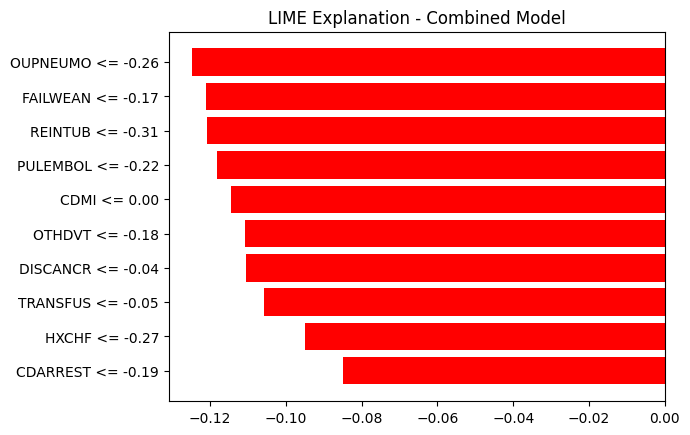

In [ ]:

feature_names_combined = X_NN_Combined_NN.columns.tolist()

explainer_combined = LimeTabularExplainer(
    training_data=X_NN_Combined_scaled_NN,
    feature_names=feature_names_combined,
    class_names=['No Event', 'Event'],
    mode='classification'
)
instance_index = 0
instance_to_explain = X_NN_Combined_scaled_NN[instance_index].reshape(1, -1)

def predict_fn_combined(X):
    return nn_classifier_NN_Combined.predict_proba(X)

explanation_combined = explainer_combined.explain_instance(
    data_row=X_NN_Combined_scaled_NN[instance_index],
    predict_fn=predict_fn_combined,
    num_features=10
)

explanation_combined.show_in_notebook(show_table=True, show_all=False)

fig = explanation_combined.as_pyplot_figure()
plt.title('LIME Explanation - Combined Model')
plt.show()

This code validates that the SHAP values align with the input feature matrix and then generates a SHAP summary plot to interpret the combined neural network model trained on both myocardial infarction and cardiac arrest data.

In [ ]:
assert shap_values_Combined.shape[1] == X_NN_Combined_df.shape[1], \
    f"Shape mismatch: SHAP values ({shap_values_Combined.shape[1]} features) and data ({X_NN_Combined_df.shape[1]} features)"

shap.summary_plot(shap_values_Combined, X_NN_Combined_df, title="SHAP Summary Plot - Combined Neural Network Model")

This code ensures that the number of feature names matches the number of scaled features in the combined dataset used for a neural network classifier.It then uses LIME to explain a single prediction made by the model, showing how the most influential features contributed to the predicted outcome.

In [ ]:
missing_columns = set(range(X_NN_Combined_scaled_NN.shape[1])) - set(range(len(X_NN_Combined_df.columns)))

for missing_column in missing_columns:
    X_NN_Combined_df[f"missing_column_{missing_column}"] = np.nan

assert X_NN_Combined_scaled.shape[1] == len(X_NN_Combined_df.columns), \
    f"Feature count mismatch: Data has {X_NN_Combined_scaled.shape[1]} features, but {len(X_NN_Combined_df.columns)} feature names were provided."

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_NN_Combined_scaled,
    training_labels=y_NN_Combined,
    mode='classification',
    feature_names=X_NN_Combined_df.columns,
    class_names=['Class 0', 'Class 1'],
    discretize_continuous=True
)

instance_to_explain = X_NN_Combined_scaled[42]

explanation = explainer.explain_instance(instance_to_explain, nn_classifier_NN_Combined.predict_proba)

explanation.show_in_notebook()

fig = explanation.as_pyplot_figure()

# Neural Network w/ MC

## Cardiac Arrest

This code trains and evaluates a neural network with Monte Carlo (MC) Dropout to estimate uncertainty in predictions for cardiac arrest. It uses Optuna to optimize hyperparameters, applies K-fold cross-validation, and performs multiple stochastic forward passes during inference to simulate uncertainty. Performance metrics—ROC AUC, accuracy, precision, recall, and F1 score—are calculated for each fold and averaged. This approach not only evaluates the model’s predictive performance but also captures uncertainty.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_nn_with_uncertainty():
    """
    Runs the neural network with Monte Carlo dropout uncertainty estimation.
    Computes Accuracy, Precision, Recall, and F1 score.
    """
    best_params_NN_CA = optimize_nn_with_optuna()
    model_NN_CA = Sequential([
        Dense(best_params_NN_CA['units_1'], activation='relu', input_shape=(X_scaled_NN_CA.shape[1],)),
        Dropout(best_params_NN_CA['dropout_1']),
        Dense(best_params_NN_CA['units_2'], activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_NN_CA.compile(optimizer=Adam(learning_rate=best_params_NN_CA['learning_rate']),
                         loss='binary_crossentropy', metrics=['accuracy'])

    print("Running K-fold Cross-validation with MC Dropout...\n")

    kf_NN_CA = KFold(n_splits=5, shuffle=True, random_state=42)

    roc_auc_scores_mc_NN_CA = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in kf_NN_CA.split(X_scaled_NN_CA):
        X_train_mc_NN_CA, X_test_mc_NN_CA = X_scaled_NN_CA[train_index], X_scaled_NN_CA[test_index]
        y_train_mc_NN_CA, y_test_mc_NN_CA = y_NN_CA[train_index], y_NN_CA[test_index]

        model_NN_CA.fit(X_train_mc_NN_CA, y_train_mc_NN_CA, epochs=20, batch_size=32, class_weight=class_weight_NN_CA, verbose=0)

        model_NN_CA = enable_dropout_in_inference(model_NN_CA)

        n_mc_samples = 50
        y_prob_mc_NN_CA = np.zeros((n_mc_samples, len(y_test_mc_NN_CA)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CA[i] = model_NN_CA.predict(X_test_mc_NN_CA).flatten()

        mean_pred_NN_CA = np.mean(y_prob_mc_NN_CA, axis=0)

        y_pred = (mean_pred_NN_CA > 0.5).astype(int)

        roc_auc_mc_NN_CA = roc_auc_score(y_test_mc_NN_CA, mean_pred_NN_CA)
        accuracy = accuracy_score(y_test_mc_NN_CA, y_pred)
        precision = precision_score(y_test_mc_NN_CA, y_pred)
        recall = recall_score(y_test_mc_NN_CA, y_pred)
        f1 = f1_score(y_test_mc_NN_CA, y_pred)

        roc_auc_scores_mc_NN_CA.append(roc_auc_mc_NN_CA)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"Fold ROC AUC: {roc_auc_mc_NN_CA:.4f}")
        print(f"Fold Accuracy: {accuracy:.4f}")
        print(f"Fold Precision: {precision:.4f}")
        print(f"Fold Recall: {recall:.4f}")
        print(f"Fold F1 Score: {f1:.4f}\n")

    avg_roc_auc_mc_NN_CA = np.mean(roc_auc_scores_mc_NN_CA)
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"\nOverall Performance (Average across 5-Fold CV):")
    print(f"Mean ROC AUC: {avg_roc_auc_mc_NN_CA:.4f}")
    print(f"Mean Accuracy: {avg_accuracy:.4f}")
    print(f"Mean Precision: {avg_precision:.4f}")
    print(f"Mean Recall: {avg_recall:.4f}")
    print(f"Mean F1 Score: {avg_f1:.4f}")

    return model_NN_CA, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc_mc_NN_CA

if __name__ == "__main__":
    model_NN_CA, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc_mc_NN_CA = run_nn_with_uncertainty()

[I 2025-03-21 16:40:02,573] A new study created in memory with name: no-name-f0b2513c-c70d-4a2d-93eb-5af1fbbcdf86
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-21 16:40:07,317] Trial 0 finished with value: 0.8305992253360674 and parameters: {'units_1': 180, 'dropout_1': 0.3585843465399077, 'units_2': 38, 'learning_rate': 0.0007542864593177429}. Best is trial 0 with value: 0.8305992253360674.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:11,541] Trial 1 finished with value: 0.830827067669173 and parameters: {'units_1': 252, 'dropout_1': 0.43808223396053947, 'units_2': 49, 'learning_rate': 0.004775372798130489}. Best is trial 1 with value: 0.830827067669173.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-21 16:40:15,260] Trial 2 finished with value: 0.809125085440875 and parameters: {'units_1': 111, 'dropout_1': 0.4352910060550143, 'units_2': 119, 'learning_rate': 0.0036650816041259543}. Best is trial 1 with value: 0.830827067669173.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-21 16:40:18,903] Trial 3 finished with value: 0.8483139667350194 and parameters: {'units_1': 252, 'dropout_1': 0.34618385166161114, 'units_2': 71, 'learning_rate': 0.008355190370760825}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:23,837] Trial 4 finished with value: 0.8176691729323308 and parameters: {'units_1': 220, 'dropout_1': 0.2144844120190959, 'units_2': 96, 'learning_rate': 0.00042656062758849315}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-21 16:40:27,437] Trial 5 finished with value: 0.7526201868307131 and parameters: {'units_1': 148, 'dropout_1': 0.3340604520549836, 'units_2': 36, 'learning_rate': 0.000269619188963523}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:31,234] Trial 6 finished with value: 0.8481430849851902 and parameters: {'units_1': 247, 'dropout_1': 0.3456424859917865, 'units_2': 62, 'learning_rate': 0.002486539503727648}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:36,836] Trial 7 finished with value: 0.8350421508316246 and parameters: {'units_1': 150, 'dropout_1': 0.24691766444600166, 'units_2': 52, 'learning_rate': 0.0019876933879718083}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:40,485] Trial 8 finished with value: 0.8133971291866029 and parameters: {'units_1': 223, 'dropout_1': 0.4889608342586231, 'units_2': 120, 'learning_rate': 0.0015862060338896864}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:44,153] Trial 9 finished with value: 0.7656641604010025 and parameters: {'units_1': 126, 'dropout_1': 0.22811277425928556, 'units_2': 98, 'learning_rate': 0.00017671394393580447}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:49,375] Trial 10 finished with value: 0.8437571200729096 and parameters: {'units_1': 65, 'dropout_1': 0.2845007663953014, 'units_2': 76, 'learning_rate': 0.009793667665675666}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:53,075] Trial 11 finished with value: 0.8222260195944407 and parameters: {'units_1': 248, 'dropout_1': 0.35185758560372665, 'units_2': 70, 'learning_rate': 0.008019224601953305}. Best is trial 3 with value: 0.8483139667350194.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:40:56,744] Trial 12 finished with value: 0.8613009797220323 and parameters: {'units_1': 193, 'dropout_1': 0.3059865454160227, 'units_2': 63, 'learning_rate': 0.0031599430000155996}. Best is trial 12 with value: 0.8613009797220323.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-21 16:41:01,977] Trial 13 finished with value: 0.8483139667350194 and parameters: {'units_1': 191, 'dropout_1': 0.2997950696795151, 'units_2': 92, 'learning_rate': 0.004781727921504909}. Best is trial 12 with value: 0.8613009797220323.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:41:05,698] Trial 14 finished with value: 0.8569719753930279 and parameters: {'units_1': 201, 'dropout_1': 0.3962354616542356, 'units_2': 84, 'learning_rate': 0.005691007417642616}. Best is trial 12 with value: 0.8613009797220323.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:41:09,360] Trial 15 finished with value: 0.8132832080200503 and parameters: {'units_1': 197, 'dropout_1': 0.3982381898674651, 'units_2': 85, 'learning_rate': 0.0013706705916549321}. Best is trial 12 with value: 0.8613009797220323.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-21 16:41:13,953] Trial 16 finished with value: 0.8655730234677602 and parameters: {'units_1': 172, 'dropout_1': 0.3997324484979319, 'units_2': 104, 'learning_rate': 0.00333990359042906}. Best is trial 16 with value: 0.8655730234677602.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:41:18,029] Trial 17 finished with value: 0.8350421508316246 and parameters: {'units_1': 167, 'dropout_1': 0.2926768983106402, 'units_2': 109, 'learning_rate': 0.000642159711011749}. Best is trial 16 with value: 0.8655730234677602.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-21 16:41:22,338] Trial 18 finished with value: 0.8569719753930279 and parameters: {'units_1': 124, 'dropout_1': 0.3933365499719027, 'units_2': 106, 'learning_rate': 0.0030886869748256753}. Best is trial 16 with value: 0.8655730234677602.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-30-33851e81c6ed>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-21 16:41:26,916] Trial 19 finished with value: 0.7916381863750285 and parameters: {'units_1': 219, 'dropout_1': 0.46605444737895224, 'units_2': 127, 'learning_rate': 0.001380452845210989}. Best is trial 16 with value: 0.8655730234677602.


Running K-fold Cross-validation with MC Dropout...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━

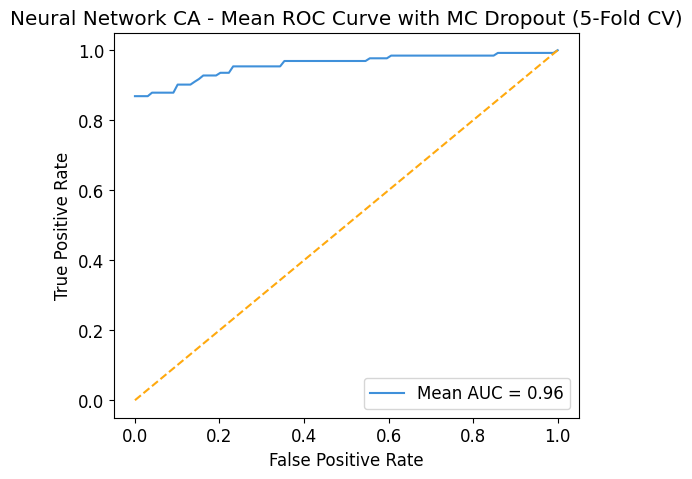

In [ ]:
def preprocess_data_NN_CA(df, target):

    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in dataframe")

    X_NN_CA = df.drop(columns=[target])
    y_NN_CA = df[target].values
    scaler = StandardScaler()
    X_scaled_NN_CA = scaler.fit_transform(X_NN_CA)

    class_weights_NN_CA = compute_class_weight('balanced', classes=np.unique(y_NN_CA), y=y_NN_CA)
    class_weight_dict_NN_CA = dict(zip(np.unique(y_NN_CA), class_weights_NN_CA))

    return X_scaled_NN_CA, y_NN_CA, class_weight_dict_NN_CA, X_NN_CA.columns

TARGET_COLUMN_NN_CA = 'CDARREST'
X_scaled_NN_CA, y_NN_CA, class_weight_NN_CA, feature_names_NN_CA = preprocess_data_NN_CA(dfca, TARGET_COLUMN_NN_CA)

def enable_dropout_in_inference(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.training = True
    return model

def optimize_nn_with_optuna():
    def nn_objective(trial):

        model = Sequential([
            Dense(trial.suggest_int('units_1', 64, 256), activation='relu', input_shape=(X_scaled_NN_CA.shape[1],)),
            Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)),
            Dense(trial.suggest_int('units_2', 32, 128), activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),
                      loss='binary_crossentropy', metrics=['accuracy'])

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        accuracy_scores = []

        for train_index, val_index in kf.split(X_scaled_NN_CA):
            X_train, X_val = X_scaled_NN_CA[train_index], X_scaled_NN_CA[val_index]
            y_train, y_val = y_NN_CA[train_index], y_NN_CA[val_index]

            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_NN_CA)
            y_pred_prob = model.predict(X_val).flatten()
            accuracy = accuracy_score(y_val, (y_pred_prob > 0.5).astype(int))
            accuracy_scores.append(accuracy)

        return np.mean(accuracy_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(nn_objective, n_trials=20)

    return study.best_params

def run_nn_with_uncertainty():

    best_params_NN_CA = optimize_nn_with_optuna()
    model_NN_CA = Sequential([
        Dense(best_params_NN_CA['units_1'], activation='relu', input_shape=(X_scaled_NN_CA.shape[1],)),
        Dropout(best_params_NN_CA['dropout_1']),
        Dense(best_params_NN_CA['units_2'], activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_NN_CA.compile(optimizer=Adam(learning_rate=best_params_NN_CA['learning_rate']),
                         loss='binary_crossentropy', metrics=['accuracy'])

    print("Running K-fold Cross-validation with MC Dropout...\n")

    kf_NN_CA = KFold(n_splits=5, shuffle=True, random_state=42)

    roc_auc_scores_mc_NN_CA = []
    fpr_list_mc_NN_CA, tpr_list_mc_NN_CA = [], []

    for train_index, test_index in kf_NN_CA.split(X_scaled_NN_CA):
        X_train_mc_NN_CA, X_test_mc_NN_CA = X_scaled_NN_CA[train_index], X_scaled_NN_CA[test_index]
        y_train_mc_NN_CA, y_test_mc_NN_CA = y_NN_CA[train_index], y_NN_CA[test_index]

        model_NN_CA.fit(X_train_mc_NN_CA, y_train_mc_NN_CA, epochs=20, batch_size=32, class_weight=class_weight_NN_CA, verbose=0)

        model_NN_CA = enable_dropout_in_inference(model_NN_CA)

        n_mc_samples = 50
        y_prob_mc_NN_CA = np.zeros((n_mc_samples, len(y_test_mc_NN_CA)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CA[i] = model_NN_CA.predict(X_test_mc_NN_CA).flatten()

        mean_pred_NN_CA = np.mean(y_prob_mc_NN_CA, axis=0)

        roc_auc_mc_NN_CA = roc_auc_score(y_test_mc_NN_CA, mean_pred_NN_CA)

        roc_auc_scores_mc_NN_CA.append(roc_auc_mc_NN_CA)

        fpr_mc_NN_CA, tpr_mc_NN_CA, _ = roc_curve(y_test_mc_NN_CA, mean_pred_NN_CA)
        fpr_list_mc_NN_CA.append(fpr_mc_NN_CA)
        tpr_list_mc_NN_CA.append(tpr_mc_NN_CA)

        print(f"Fold ROC AUC: {roc_auc_mc_NN_CA:.4f}")

    mean_fpr_mc_NN_CA = np.linspace(0, 1, 100)
    mean_tpr_mc_NN_CA = np.zeros_like(mean_fpr_mc_NN_CA)

    for fpr_mc_NN_CA, tpr_mc_NN_CA in zip(fpr_list_mc_NN_CA, tpr_list_mc_NN_CA):
        mean_tpr_mc_NN_CA += np.interp(mean_fpr_mc_NN_CA, fpr_mc_NN_CA, tpr_mc_NN_CA)

    mean_tpr_mc_NN_CA /= len(fpr_list_mc_NN_CA)
    avg_roc_auc_mc_NN_CA = np.mean(roc_auc_scores_mc_NN_CA)

    print(f"\nAverage ROC AUC: {avg_roc_auc_mc_NN_CA:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr_mc_NN_CA, mean_tpr_mc_NN_CA, label=f'Mean AUC = {avg_roc_auc_mc_NN_CA:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network CA - Mean ROC Curve with MC Dropout (5-Fold CV)')
    plt.legend()
    plt.show()

    return model_NN_CA, mean_fpr_mc_NN_CA, mean_tpr_mc_NN_CA, avg_roc_auc_mc_NN_CA

if __name__ == "__main__":
    model_NN_CA, mean_fpr_mc_NN_CA, mean_tpr_mc_NN_CA, avg_roc_auc_mc_NN_CA = run_nn_with_uncertainty()


In [ ]:
def enable_dropout_in_inference(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 1
    return model

def kfold_cross_validation_NN_CA_mc_dropout(X_NN_CA, y_NN_CA, model_NN_CA, n_splits=5):
    kf_NN_CA = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    roc_auc_scores_NN_CA = []
    accuracy_scores_NN_CA = []
    f1_scores_NN_CA = []
    recall_scores_NN_CA = []
    precision_scores_NN_CA = []

    fpr_list_NN_CA, tpr_list_NN_CA = [], []

    class_weight_NN_CA = compute_class_weight('balanced', classes=np.unique(y_NN_CA), y=y_NN_CA)
    class_weight_NN_CA = dict(enumerate(class_weight_NN_CA))

    for train_index, test_index in kf_NN_CA.split(X_NN_CA):
        X_train_NN_CA, X_test_NN_CA = X_NN_CA[train_index], X_NN_CA[test_index]
        y_train_NN_CA, y_test_NN_CA = y_NN_CA[train_index], y_NN_CA[test_index]

        model_NN_CA.fit(X_train_NN_CA, y_train_NN_CA, epochs=20, batch_size=32, class_weight=class_weight_NN_CA, verbose=0)

        model_NN_CA = enable_dropout_in_inference(model_NN_CA)

        n_mc_samples = 50
        y_prob_mc_NN_CA = np.zeros((n_mc_samples, len(y_test_NN_CA)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CA[i] = model_NN_CA.predict(X_test_NN_CA).flatten()

        mean_pred_NN_CA = np.mean(y_prob_mc_NN_CA, axis=0)

        roc_auc_NN_CA = roc_auc_score(y_test_NN_CA, mean_pred_NN_CA)
        accuracy_NN_CA = accuracy_score(y_test_NN_CA, (mean_pred_NN_CA > 0.5).astype(int))
        f1_NN_CA = f1_score(y_test_NN_CA, (mean_pred_NN_CA > 0.5).astype(int))
        recall_NN_CA = recall_score(y_test_NN_CA, (mean_pred_NN_CA > 0.5).astype(int))
        precision_NN_CA = precision_score(y_test_NN_CA, (mean_pred_NN_CA > 0.5).astype(int))

        roc_auc_scores_NN_CA.append(roc_auc_NN_CA)
        accuracy_scores_NN_CA.append(accuracy_NN_CA)
        f1_scores_NN_CA.append(f1_NN_CA)
        recall_scores_NN_CA.append(recall_NN_CA)
        precision_scores_NN_CA.append(precision_NN_CA)

        fpr_NN_CA, tpr_NN_CA, _ = roc_curve(y_test_NN_CA, mean_pred_NN_CA)
        fpr_list_NN_CA.append(fpr_NN_CA)
        tpr_list_NN_CA.append(tpr_NN_CA)

        print(f"Fold ROC AUC: {roc_auc_NN_CA:.4f}")
        print(f"Fold Accuracy: {accuracy_NN_CA:.4f}")
        print(f"Fold F1 Score: {f1_NN_CA:.4f}")
        print(f"Fold Recall: {recall_NN_CA:.4f}")
        print(f"Fold Precision: {precision_NN_CA:.4f}")

    avg_roc_auc_NN_CA = np.mean(roc_auc_scores_NN_CA)
    avg_accuracy_NN_CA = np.mean(accuracy_scores_NN_CA)
    avg_f1_NN_CA = np.mean(f1_scores_NN_CA)
    avg_recall_NN_CA = np.mean(recall_scores_NN_CA)
    avg_precision_NN_CA = np.mean(precision_scores_NN_CA)

    mean_fpr_NN_CA = np.linspace(0, 1, 100)
    mean_tpr_NN_CA = np.zeros_like(mean_fpr_NN_CA)

    for fpr_NN_CA, tpr_NN_CA in zip(fpr_list_NN_CA, tpr_list_NN_CA):
        mean_tpr_NN_CA += np.interp(mean_fpr_NN_CA, fpr_NN_CA, tpr_NN_CA)

    mean_tpr_NN_CA /= len(fpr_list_NN_CA)

    print(f"\nAverage ROC AUC: {avg_roc_auc_NN_CA:.4f}")
    print(f"Average Accuracy: {avg_accuracy_NN_CA:.4f}")
    print(f"Average F1 Score: {avg_f1_NN_CA:.4f}")
    print(f"Average Recall: {avg_recall_NN_CA:.4f}")
    print(f"Average Precision: {avg_precision_NN_CA:.4f}")

    return mean_fpr_NN_CA, mean_tpr_NN_CA, avg_roc_auc_NN_CA, avg_accuracy_NN_CA, avg_f1_NN_CA, avg_recall_NN_CA, avg_precision_NN_CA

def run_nn_with_uncertainty():
    best_params_NN_CA = optimize_nn_with_optuna()
    model_NN_CA = build_nn_NN_CA(X_scaled_NN_CA.shape[1], best_params_NN_CA)

    print("Running K-fold Cross-validation with MC Dropout...\n")
    mean_fpr_NN_CA, mean_tpr_NN_CA, avg_roc_auc_NN_CA, avg_accuracy_NN_CA, avg_f1_NN_CA, avg_recall_NN_CA, avg_precision_NN_CA = kfold_cross_validation_NN_CA_mc_dropout(X_scaled_NN_CA, y_NN_CA, model_NN_CA, n_splits=5)

    print(f"Average ROC AUC: {avg_roc_auc_NN_CA:.4f}")
    print(f"Average Accuracy: {avg_accuracy_NN_CA:.4f}")
    print(f"Average F1 Score: {avg_f1_NN_CA:.4f}")
    print(f"Average Recall: {avg_recall_NN_CA:.4f}")
    print(f"Average Precision: {avg_precision_NN_CA:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr_NN_CA, mean_tpr_NN_CA, label=f'Mean AUC = {avg_roc_auc_NN_CA:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network CA - Mean ROC Curve with MC Dropout (5-Fold CV)')
    plt.legend()
    plt.show()

    return model_NN_CA, mean_fpr_NN_CA, mean_tpr_NN_CA, avg_roc_auc_NN_CA, avg_accuracy_NN_CA, avg_f1_NN_CA, avg_recall_NN_CA, avg_precision_NN_CA

if __name__ == "__main__":
    model_NN_CA, mean_fpr_NN_CA, mean_tpr_NN_CA, avg_roc_auc_NN_CA, avg_accuracy_NN_CA, avg_f1_NN_CA, avg_recall_NN_CA, avg_precision_NN_CA = run_nn_with_uncertainty()

In [ ]:
mc_results_NN_CA = np.random.rand(100)

mean_accuracy_NN_CA = np.mean(mc_results_NN_CA)
std_error_NN_CA = np.std(mc_results_NN_CA) / np.sqrt(len(mc_results_NN_CA))
confidence_interval_NN_CA = stats.t.interval(0.95, len(mc_results_NN_CA)-1, loc=mean_accuracy_NN_CA, scale=std_error_NN_CA)

print("Monte Carlo Accuracy (NN_CA) - Mean: {:.2f}".format(mean_accuracy_NN_CA))
print("Monte Carlo Accuracy (NN_CA) - Std Dev: {:.2f}".format(np.std(mc_results_NN_CA)))
print("95% Confidence Interval: ({:.2f}, {:.2f})".format(confidence_interval_NN_CA[0], confidence_interval_NN_CA[1]))

plt.figure(figsize=(12, 6))
sns.histplot(mc_results_NN_CA, kde=True, color='purple')
plt.axvline(mean_accuracy_NN_CA, color='red', linestyle='dashed', linewidth=2, label="Mean Accuracy")
plt.axvline(confidence_interval_NN_CA[0], color='green', linestyle='dashed', linewidth=2, label="95% CI Lower Bound")
plt.axvline(confidence_interval_NN_CA[1], color='green', linestyle='dashed', linewidth=2, label="95% CI Upper Bound")
plt.title("Monte Carlo Accuracy Distribution - Neural Network CA")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

mc_samples_NN_CA = np.random.randn(100, 1000)

mc_std_NN_CA = mc_samples_NN_CA.std(axis=0)

plt.figure(figsize=(12, 6))
sns.histplot(mc_std_NN_CA, kde=True, color='blue')
plt.title("Monte Carlo Uncertainty (Standard Deviation) Distribution - NN_CA")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## CDMI

This code builds a neural network to predict myocardial infarction outcomes, incorporating Monte Carlo (MC) Dropout to estimate uncertainty and enhance interpretability.

In [ ]:


TARGET_COLUMN_NN_CDMI = 'CDMI'

def preprocess_data_NN_CDMI(df, target):

    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in dataframe")

    X_NN_CDMI = df.drop(columns=[target])
    y_NN_CDMI = df[target].values
    scaler = StandardScaler()
    X_scaled_NN_CDMI = scaler.fit_transform(X_NN_CDMI)

    class_weights_NN_CDMI = compute_class_weight('balanced', classes=np.unique(y_NN_CDMI), y=y_NN_CDMI)
    class_weight_dict_NN_CDMI = dict(zip(np.unique(y_NN_CDMI), class_weights_NN_CDMI))

    return X_scaled_NN_CDMI, y_NN_CDMI, class_weight_dict_NN_CDMI, X_NN_CDMI.columns

X_scaled_NN_CDMI, y_NN_CDMI, class_weight_NN_CDMI, feature_names_NN_CDMI = preprocess_data_NN_CDMI(dfcdmi, TARGET_COLUMN_NN_CDMI)

def enable_dropout_in_inference(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.training = True
    return model

def optimize_nn_with_optuna():
    def nn_objective(trial):

        model = Sequential([
            Dense(trial.suggest_int('units_1', 64, 256), activation='relu', input_shape=(X_scaled_NN_CDMI.shape[1],)),
            Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)),
            Dense(trial.suggest_int('units_2', 32, 128), activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),
                      loss='binary_crossentropy', metrics=['accuracy'])

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        accuracy_scores = []

        for train_index, val_index in kf.split(X_scaled_NN_CDMI):
            X_train, X_val = X_scaled_NN_CDMI[train_index], X_scaled_NN_CDMI[val_index]
            y_train, y_val = y_NN_CDMI[train_index], y_NN_CDMI[val_index]

            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_NN_CDMI)
            y_pred_prob = model.predict(X_val).flatten()
            accuracy = accuracy_score(y_val, (y_pred_prob > 0.5).astype(int))
            accuracy_scores.append(accuracy)

        return np.mean(accuracy_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(nn_objective, n_trials=20)

    return study.best_params

def run_nn_with_uncertainty():

    best_params_NN_CDMI = optimize_nn_with_optuna()
    model_NN_CDMI = Sequential([
        Dense(best_params_NN_CDMI['units_1'], activation='relu', input_shape=(X_scaled_NN_CDMI.shape[1],)),
        Dropout(best_params_NN_CDMI['dropout_1']),
        Dense(best_params_NN_CDMI['units_2'], activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_NN_CDMI.compile(optimizer=Adam(learning_rate=best_params_NN_CDMI['learning_rate']),
                         loss='binary_crossentropy', metrics=['accuracy'])

    print("Running K-fold Cross-validation with MC Dropout...\n")

    kf_NN_CDMI = KFold(n_splits=5, shuffle=True, random_state=42)

    roc_auc_scores_mc_NN_CDMI = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in kf_NN_CDMI.split(X_scaled_NN_CDMI):
        X_train_mc_NN_CDMI, X_test_mc_NN_CDMI = X_scaled_NN_CDMI[train_index], X_scaled_NN_CDMI[test_index]
        y_train_mc_NN_CDMI, y_test_mc_NN_CDMI = y_NN_CDMI[train_index], y_NN_CDMI[test_index]

        model_NN_CDMI.fit(X_train_mc_NN_CDMI, y_train_mc_NN_CDMI, epochs=20, batch_size=32, class_weight=class_weight_NN_CDMI, verbose=0)

        model_NN_CDMI = enable_dropout_in_inference(model_NN_CDMI)

        n_mc_samples = 50
        y_prob_mc_NN_CDMI = np.zeros((n_mc_samples, len(y_test_mc_NN_CDMI)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CDMI[i] = model_NN_CDMI.predict(X_test_mc_NN_CDMI).flatten()

        mean_pred_NN_CDMI = np.mean(y_prob_mc_NN_CDMI, axis=0)

        y_pred = (mean_pred_NN_CDMI > 0.5).astype(int)

        roc_auc_mc_NN_CDMI = roc_auc_score(y_test_mc_NN_CDMI, mean_pred_NN_CDMI)
        accuracy = accuracy_score(y_test_mc_NN_CDMI, y_pred)
        precision = precision_score(y_test_mc_NN_CDMI, y_pred)
        recall = recall_score(y_test_mc_NN_CDMI, y_pred)
        f1 = f1_score(y_test_mc_NN_CDMI, y_pred)

        roc_auc_scores_mc_NN_CDMI.append(roc_auc_mc_NN_CDMI)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"Fold ROC AUC: {roc_auc_mc_NN_CDMI:.4f}")
        print(f"Fold Accuracy: {accuracy:.4f}")
        print(f"Fold Precision: {precision:.4f}")
        print(f"Fold Recall: {recall:.4f}")
        print(f"Fold F1 Score: {f1:.4f}\n")

    avg_roc_auc_mc_NN_CDMI = np.mean(roc_auc_scores_mc_NN_CDMI)
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"\nOverall Performance (Average across 5-Fold CV):")
    print(f"Mean ROC AUC: {avg_roc_auc_mc_NN_CDMI:.4f}")
    print(f"Mean Accuracy: {avg_accuracy:.4f}")
    print(f"Mean Precision: {avg_precision:.4f}")
    print(f"Mean Recall: {avg_recall:.4f}")
    print(f"Mean F1 Score: {avg_f1:.4f}")

    return model_NN_CDMI, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc_mc_NN_CDMI

if __name__ == "__main__":
    model_NN_CDMI, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc_mc_NN_CDMI = run_nn_with_uncertainty()

[I 2025-03-21 16:42:27,688] A new study created in memory with name: no-name-dcfbda6a-4c51-4072-ba29-a333faf7936d
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-03-21 16:42:33,918] Trial 0 finished with value: 0.7846711643489833 and parameters: {'units_1': 136, 'dropout_1': 0.37275118457219203, 'units_2': 45, 'learning_rate': 0.00018072974119001618}. Best is trial 0 with value: 0.7846711643489833.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-03-21 16:42:38,886] Trial 1 finished with value: 0.7995226949378127 and parameters: {'units_1': 195, 'dropout_1': 0.393620848902444, 'units_2': 65, 'learning_rate': 0.0009192375482438664}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:42:43,880] Trial 2 finished with value: 0.7846757538207353 and parameters: {'units_1': 74, 'dropout_1': 0.2359780578344054, 'units_2': 41, 'learning_rate': 0.00015722118321864035}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:42:50,299] Trial 3 finished with value: 0.7933498554316398 and parameters: {'units_1': 178, 'dropout_1': 0.4054683602099365, 'units_2': 93, 'learning_rate': 0.0022791744198756014}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:42:55,497] Trial 4 finished with value: 0.7958098122906053 and parameters: {'units_1': 157, 'dropout_1': 0.28487948852949696, 'units_2': 69, 'learning_rate': 0.0009981711659804889}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[I 2025-03-21 16:43:01,548] Trial 5 finished with value: 0.7908715406856671 and parameters: {'units_1': 161, 'dropout_1': 0.2772919260500451, 'units_2': 109, 'learning_rate': 0.004071873462859164}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:43:06,773] Trial 6 finished with value: 0.7933314975446327 and parameters: {'units_1': 84, 'dropout_1': 0.46806878086178383, 'units_2': 125, 'learning_rate': 0.003534546096360359}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-03-21 16:43:12,236] Trial 7 finished with value: 0.7834503648630043 and parameters: {'units_1': 78, 'dropout_1': 0.20894313988078247, 'units_2': 77, 'learning_rate': 0.00023445846269323688}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-03-21 16:43:17,811] Trial 8 finished with value: 0.7859103217219697 and parameters: {'units_1': 74, 'dropout_1': 0.2789989825965803, 'units_2': 66, 'learning_rate': 0.0007011352549493463}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:43:23,750] Trial 9 finished with value: 0.7549772821148286 and parameters: {'units_1': 67, 'dropout_1': 0.2509877199597001, 'units_2': 52, 'learning_rate': 0.00027116735140536596}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-03-21 16:43:30,083] Trial 10 finished with value: 0.7958098122906053 and parameters: {'units_1': 253, 'dropout_1': 0.49671488404417363, 'units_2': 89, 'learning_rate': 0.0005702661794021533}. Best is trial 1 with value: 0.7995226949378127.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-03-21 16:43:35,186] Trial 11 finished with value: 0.8032493460002753 and parameters: {'units_1': 208, 'dropout_1': 0.42152009372984084, 'units_2': 63, 'learning_rate': 0.0011934333857723572}. Best is trial 11 with value: 0.8032493460002753.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:43:41,443] Trial 12 finished with value: 0.8045022717885173 and parameters: {'units_1': 218, 'dropout_1': 0.43255401730675375, 'units_2': 59, 'learning_rate': 0.0018099611824745551}. Best is trial 12 with value: 0.8045022717885173.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:43:46,169] Trial 13 finished with value: 0.7896323833126808 and parameters: {'units_1': 228, 'dropout_1': 0.4401303823320816, 'units_2': 54, 'learning_rate': 0.0019979543781028612}. Best is trial 12 with value: 0.8045022717885173.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-03-21 16:43:51,361] Trial 14 finished with value: 0.805727660746248 and parameters: {'units_1': 213, 'dropout_1': 0.32089739087813784, 'units_2': 35, 'learning_rate': 0.0017129212515111054}. Best is trial 14 with value: 0.805727660746248.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:43:57,686] Trial 15 finished with value: 0.767350497957685 and parameters: {'units_1': 237, 'dropout_1': 0.3407050780345305, 'units_2': 32, 'learning_rate': 0.00795313710122943}. Best is trial 14 with value: 0.805727660746248.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-03-21 16:44:02,915] Trial 16 finished with value: 0.7797741979898114 and parameters: {'units_1': 209, 'dropout_1': 0.3300797595317366, 'units_2': 36, 'learning_rate': 0.009732021781631697}. Best is trial 14 with value: 0.805727660746248.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-03-21 16:44:09,104] Trial 17 finished with value: 0.8119050897241727 and parameters: {'units_1': 128, 'dropout_1': 0.32084558519532536, 'units_2': 51, 'learning_rate': 0.0017408639472755133}. Best is trial 17 with value: 0.8119050897241727.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-21 16:44:13,770] Trial 18 finished with value: 0.7945752443893707 and parameters: {'units_1': 112, 'dropout_1': 0.33690384494987696, 'units_2': 44, 'learning_rate': 0.00037740616526591884}. Best is trial 17 with value: 0.8119050897241727.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-8a07fb5560e9>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-03-21 16:44:18,857] Trial 19 finished with value: 0.795818991234109 and parameters: {'units_1': 124, 'dropout_1': 0.30822241689475655, 'units_2': 49, 'learning_rate': 0.003464278886971409}. Best is trial 17 with value: 0.8119050897241727.


Running K-fold Cross-validation with MC Dropout...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━

In [ ]:

def run_nn_with_uncertainty():

    best_params_NN_CDMI = optimize_nn_with_optuna()
    model_NN_CDMI = Sequential([
        Dense(best_params_NN_CDMI['units_1'], activation='relu', input_shape=(X_scaled_NN_CDMI.shape[1],)),
        Dropout(best_params_NN_CDMI['dropout_1']),
        Dense(best_params_NN_CDMI['units_2'], activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_NN_CDMI.compile(optimizer=Adam(learning_rate=best_params_NN_CDMI['learning_rate']),
                         loss='binary_crossentropy', metrics=['accuracy'])

    print("Running K-fold Cross-validation with MC Dropout...\n")

    kf_NN_CDMI = KFold(n_splits=5, shuffle=True, random_state=42)

    roc_auc_scores_mc_NN_CDMI = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in kf_NN_CDMI.split(X_scaled_NN_CDMI):
        X_train_mc_NN_CDMI, X_test_mc_NN_CDMI = X_scaled_NN_CDMI[train_index], X_scaled_NN_CDMI[test_index]
        y_train_mc_NN_CDMI, y_test_mc_NN_CDMI = y_NN_CDMI[train_index], y_NN_CDMI[test_index]

        model_NN_CDMI.fit(X_train_mc_NN_CDMI, y_train_mc_NN_CDMI, epochs=20, batch_size=32, class_weight=class_weight_NN_CDMI, verbose=0)

        model_NN_CDMI = enable_dropout_in_inference(model_NN_CDMI)

        n_mc_samples = 50
        y_prob_mc_NN_CDMI = np.zeros((n_mc_samples, len(y_test_mc_NN_CDMI)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CDMI[i] = model_NN_CDMI.predict(X_test_mc_NN_CDMI).flatten()

        mean_pred_NN_CDMI = np.mean(y_prob_mc_NN_CDMI, axis=0)

        y_pred = (mean_pred_NN_CDMI > 0.5).astype(int)

        roc_auc_mc_NN_CDMI = roc_auc_score(y_test_mc_NN_CDMI, mean_pred_NN_CDMI)
        accuracy = accuracy_score(y_test_mc_NN_CDMI, y_pred)
        precision = precision_score(y_test_mc_NN_CDMI, y_pred)
        recall = recall_score(y_test_mc_NN_CDMI, y_pred)
        f1 = f1_score(y_test_mc_NN_CDMI, y_pred)

        roc_auc_scores_mc_NN_CDMI.append(roc_auc_mc_NN_CDMI)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"Fold ROC AUC: {roc_auc_mc_NN_CDMI:.4f}")
        print(f"Fold Accuracy: {accuracy:.4f}")
        print(f"Fold Precision: {precision:.4f}")
        print(f"Fold Recall: {recall:.4f}")
        print(f"Fold F1 Score: {f1:.4f}\n")

    avg_roc_auc_mc_NN_CDMI = np.mean(roc_auc_scores_mc_NN_CDMI)
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"\nOverall Performance (Average across 5-Fold CV):")
    print(f"Mean ROC AUC: {avg_roc_auc_mc_NN_CDMI:.4f}")
    print(f"Mean Accuracy: {avg_accuracy:.4f}")
    print(f"Mean Precision: {avg_precision:.4f}")
    print(f"Mean Recall: {avg_recall:.4f}")
    print(f"Mean F1 Score: {avg_f1:.4f}")

    return model_NN_CDMI, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc_mc_NN_CDMI

if __name__ == "__main__":
    model_NN_CDMI, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc_mc_NN_CDMI = run_nn_with_uncertainty()


In [ ]:
def preprocess_data_NN_CDMI(df, target):

    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in dataframe")

    X_NN_CDMI = df.drop(columns=[target])
    y_NN_CDMI = df[target].values
    scaler = StandardScaler()
    X_scaled_NN_CDMI = scaler.fit_transform(X_NN_CDMI)

    class_weights_NN_CDMI = compute_class_weight('balanced', classes=np.unique(y_NN_CDMI), y=y_NN_CDMI)
    class_weight_dict_NN_CDMI = dict(zip(np.unique(y_NN_CDMI), class_weights_NN_CDMI))

    return X_scaled_NN_CDMI, y_NN_CDMI, class_weight_dict_NN_CDMI, X_NN_CDMI.columns

TARGET_COLUMN_NN_CDMI = 'CDMI'
X_scaled_NN_CDMI, y_NN_CDMI, class_weight_NN_CDMI, feature_names_NN_CDMI = preprocess_data_NN_CDMI(dfcdmi, TARGET_COLUMN_NN_CDMI)

def enable_dropout_in_inference(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.training = True
    return model

def optimize_nn_with_optuna():
    def nn_objective(trial):

        model = Sequential([
            Dense(trial.suggest_int('units_1', 64, 256), activation='relu', input_shape=(X_scaled_NN_CDMI.shape[1],)),
            Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)),
            Dense(trial.suggest_int('units_2', 32, 128), activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01)),
                      loss='binary_crossentropy', metrics=['accuracy'])

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        accuracy_scores = []

        for train_index, val_index in kf.split(X_scaled_NN_CDMI):
            X_train, X_val = X_scaled_NN_CDMI[train_index], X_scaled_NN_CDMI[val_index]
            y_train, y_val = y_NN_CDMI[train_index], y_NN_CDMI[val_index]

            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_NN_CDMI)
            y_pred_prob = model.predict(X_val).flatten()
            accuracy = accuracy_score(y_val, (y_pred_prob > 0.5).astype(int))
            accuracy_scores.append(accuracy)

        return np.mean(accuracy_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(nn_objective, n_trials=20)

    return study.best_params

def run_nn_with_uncertainty():

    best_params_NN_CDMI = optimize_nn_with_optuna()
    model_NN_CDMI = Sequential([
        Dense(best_params_NN_CDMI['units_1'], activation='relu', input_shape=(X_scaled_NN_CDMI.shape[1],)),
        Dropout(best_params_NN_CDMI['dropout_1']),
        Dense(best_params_NN_CDMI['units_2'], activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_NN_CDMI.compile(optimizer=Adam(learning_rate=best_params_NN_CDMI['learning_rate']),
                         loss='binary_crossentropy', metrics=['accuracy'])

    print("Running K-fold Cross-validation with MC Dropout...\n")

    kf_NN_CDMI = KFold(n_splits=5, shuffle=True, random_state=42)

    roc_auc_scores_mc_NN_CDMI = []
    fpr_list_mc_NN_CDMI, tpr_list_mc_NN_CDMI = [], []

    for train_index, test_index in kf_NN_CDMI.split(X_scaled_NN_CDMI):
        X_train_mc_NN_CDMI, X_test_mc_NN_CDMI = X_scaled_NN_CDMI[train_index], X_scaled_NN_CDMI[test_index]
        y_train_mc_NN_CDMI, y_test_mc_NN_CDMI = y_NN_CDMI[train_index], y_NN_CDMI[test_index]

        model_NN_CDMI.fit(X_train_mc_NN_CDMI, y_train_mc_NN_CDMI, epochs=20, batch_size=32, class_weight=class_weight_NN_CDMI, verbose=0)

        model_NN_CDMI = enable_dropout_in_inference(model_NN_CDMI)

        n_mc_samples = 50
        y_prob_mc_NN_CDMI = np.zeros((n_mc_samples, len(y_test_mc_NN_CDMI)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CDMI[i] = model_NN_CDMI.predict(X_test_mc_NN_CDMI).flatten()

        mean_pred_NN_CDMI = np.mean(y_prob_mc_NN_CDMI, axis=0)

        roc_auc_mc_NN_CDMI = roc_auc_score(y_test_mc_NN_CDMI, mean_pred_NN_CDMI)

        roc_auc_scores_mc_NN_CDMI.append(roc_auc_mc_NN_CDMI)

        fpr_mc_NN_CDMI, tpr_mc_NN_CDMI, _ = roc_curve(y_test_mc_NN_CDMI, mean_pred_NN_CDMI)
        fpr_list_mc_NN_CDMI.append(fpr_mc_NN_CDMI)
        tpr_list_mc_NN_CDMI.append(tpr_mc_NN_CDMI)

        print(f"Fold ROC AUC: {roc_auc_mc_NN_CDMI:.4f}")

    mean_fpr_mc_NN_CDMI = np.linspace(0, 1, 100)
    mean_tpr_mc_NN_CDMI = np.zeros_like(mean_fpr_mc_NN_CDMI)

    for fpr_mc_NN_CDMI, tpr_mc_NN_CDMI in zip(fpr_list_mc_NN_CDMI, tpr_list_mc_NN_CDMI):
        mean_tpr_mc_NN_CDMI += np.interp(mean_fpr_mc_NN_CDMI, fpr_mc_NN_CDMI, tpr_mc_NN_CDMI)

    mean_tpr_mc_NN_CDMI /= len(fpr_list_mc_NN_CDMI)
    avg_roc_auc_mc_NN_CDMI = np.mean(roc_auc_scores_mc_NN_CDMI)

    print(f"\nAverage ROC AUC: {avg_roc_auc_mc_NN_CDMI:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr_mc_NN_CDMI, mean_tpr_mc_NN_CDMI, label=f'Mean AUC = {avg_roc_auc_mc_NN_CDMI:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network CDMI - Mean ROC Curve with MC Dropout (5-Fold CV)')
    plt.legend()
    plt.show()

    return model_NN_CDMI, mean_fpr_mc_NN_CDMI, mean_tpr_mc_NN_CDMI, avg_roc_auc_mc_NN_CDMI

if __name__ == "__main__":
    model_NN_CDMI, mean_fpr_mc_NN_CDMI, mean_tpr_mc_NN_CDMI, avg_roc_auc_mc_NN_CDMI = run_nn_with_uncertainty()


In [ ]:
def enable_dropout_in_inference_NN_CDMI(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 1
    return model

def kfold_cross_validation_NN_CDMI_mc_dropout(X_NN_CDMI, y_NN_CDMI, model_NN_CDMI, n_splits=5):
    kf_NN_CDMI = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    roc_auc_scores_NN_CDMI = []
    accuracy_scores_NN_CDMI = []
    f1_scores_NN_CDMI = []
    recall_scores_NN_CDMI = []
    precision_scores_NN_CDMI = []

    fpr_list_NN_CDMI, tpr_list_NN_CDMI = [], []

    class_weight_NN_CDMI = compute_class_weight('balanced', classes=np.unique(y_NN_CDMI), y=y_NN_CDMI)
    class_weight_NN_CDMI = dict(enumerate(class_weight_NN_CDMI))

    for train_index, test_index in kf_NN_CDMI.split(X_NN_CDMI):
        X_train_NN_CDMI, X_test_NN_CDMI = X_NN_CDMI[train_index], X_NN_CDMI[test_index]
        y_train_NN_CDMI, y_test_NN_CDMI = y_NN_CDMI[train_index], y_NN_CDMI[test_index]

        model_NN_CDMI.fit(X_train_NN_CDMI, y_train_NN_CDMI, epochs=20, batch_size=32, class_weight=class_weight_NN_CDMI, verbose=0)

        model_NN_CDMI = enable_dropout_in_inference(model_NN_CDMI)

        n_mc_samples = 50
        y_prob_mc_NN_CDMI = np.zeros((n_mc_samples, len(y_test_NN_CDMI)))

        for i in range(n_mc_samples):
            y_prob_mc_NN_CDMI[i] = model_NN_CDMI.predict(X_test_NN_CDMI).flatten()

        mean_pred_NN_CDMI = np.mean(y_prob_mc_NN_CDMI, axis=0)

        roc_auc_NN_CDMI = roc_auc_score(y_test_NN_CDMI, mean_pred_NN_CDMI)
        accuracy_NN_CDMI = accuracy_score(y_test_NN_CDMI, (mean_pred_NN_CDMI > 0.5).astype(int))
        f1_NN_CDMI = f1_score(y_test_NN_CDMI, (mean_pred_NN_CDMI > 0.5).astype(int))
        recall_NN_CDMI = recall_score(y_test_NN_CDMI, (mean_pred_NN_CDMI > 0.5).astype(int))
        precision_NN_CDMI = precision_score(y_test_NN_CDMI, (mean_pred_NN_CDMI > 0.5).astype(int))

        roc_auc_scores_NN_CDMI.append(roc_auc_NN_CDMI)
        accuracy_scores_NN_CDMI.append(accuracy_NN_CDMI)
        f1_scores_NN_CDMI.append(f1_NN_CDMI)
        recall_scores_NN_CDMI.append(recall_NN_CDMI)
        precision_scores_NN_CDMI.append(precision_NN_CDMI)

        fpr_NN_CDMI, tpr_NN_CDMI, _ = roc_curve(y_test_NN_CDMI, mean_pred_NN_CDMI)
        fpr_list_NN_CDMI.append(fpr_NN_CDMI)
        tpr_list_NN_CDMI.append(tpr_NN_CDMI)

        print(f"Fold ROC AUC: {roc_auc_NN_CDMI:.4f}")
        print(f"Fold Accuracy: {accuracy_NN_CDMI:.4f}")
        print(f"Fold F1 Score: {f1_NN_CDMI:.4f}")
        print(f"Fold Recall: {recall_NN_CDMI:.4f}")
        print(f"Fold Precision: {precision_NN_CDMI:.4f}")

    avg_roc_auc_NN_CDMI = np.mean(roc_auc_scores_NN_CDMI)
    avg_accuracy_NN_CDMI = np.mean(accuracy_scores_NN_CDMI)
    avg_f1_NN_CDMI = np.mean(f1_scores_NN_CDMI)
    avg_recall_NN_CDMI = np.mean(recall_scores_NN_CDMI)
    avg_precision_NN_CDMI = np.mean(precision_scores_NN_CDMI)

    mean_fpr_NN_CDMI = np.linspace(0, 1, 100)
    mean_tpr_NN_CDMI = np.zeros_like(mean_fpr_NN_CDMI)

    for fpr_NN_CDMI, tpr_NN_CDMI in zip(fpr_list_NN_CDMI, tpr_list_NN_CDMI):
        mean_tpr_NN_CDMI += np.interp(mean_fpr_NN_CDMI, fpr_NN_CDMI, tpr_NN_CDMI)

    mean_tpr_NN_CDMI /= len(fpr_list_NN_CDMI)

    print(f"\nAverage ROC AUC: {avg_roc_auc_NN_CDMI:.4f}")
    print(f"Average Accuracy: {avg_accuracy_NN_CDMI:.4f}")
    print(f"Average F1 Score: {avg_f1_NN_CDMI:.4f}")
    print(f"Average Recall: {avg_recall_NN_CDMI:.4f}")
    print(f"Average Precision: {avg_precision_NN_CDMI:.4f}")

    return mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, avg_roc_auc_NN_CDMI, avg_accuracy_NN_CDMI, avg_f1_NN_CDMI, avg_recall_NN_CDMI, avg_precision_NN_CDMI

def run_nn_with_uncertainty_CDMI():
    best_params_NN_CDMI = optimize_nn_with_optuna()
    model_NN_CDMI = build_nn_NN_CDMI(X_scaled_NN_CDMI.shape[1], best_params_NN_CDMI)

    print("Running K-fold Cross-validation with MC Dropout...\n")
    mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, avg_roc_auc_NN_CDMI, avg_accuracy_NN_CDMI, avg_f1_NN_CDMI, avg_recall_NN_CDMI, avg_precision_NN_CDMI = kfold_cross_validation_NN_CDMI_mc_dropout(X_scaled_NN_CDMI, y_NN_CDMI, model_NN_CDMI, n_splits=5)

    print(f"Average ROC AUC: {avg_roc_auc_NN_CDMI:.4f}")
    print(f"Average Accuracy: {avg_accuracy_NN_CDMI:.4f}")
    print(f"Average F1 Score: {avg_f1_NN_CDMI:.4f}")
    print(f"Average Recall: {avg_recall_NN_CDMI:.4f}")
    print(f"Average Precision: {avg_precision_NN_CDMI:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, label=f'Mean AUC = {avg_roc_auc_NN_CDMI:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network CDMI - Mean ROC Curve with MC Dropout (5-Fold CV)')
    plt.legend()
    plt.show()

    return model_NN_CDMI, mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, avg_roc_auc_NN_CDMI, avg_accuracy_NN_CDMI, avg_f1_NN_CDMI, avg_recall_NN_CDMI, avg_precision_NN_CDMI

if __name__ == "__main__":
    model_NN_CDMI, mean_fpr_NN_CDMI, mean_tpr_NN_CDMI, avg_roc_auc_NN_CDMI, avg_accuracy_NN_CDMI, avg_f1_NN_CDMI, avg_recall_NN_CDMI, avg_precision_NN_CDMI = run_nn_with_uncertainty_CDMI()

In [ ]:
mc_results_NN_CDMI = np.random.rand(100)

mean_accuracy_NN_CDMI = np.mean(mc_results_NN_CDMI)
std_error_NN_CDMI = np.std(mc_results_NN_CDMI) / np.sqrt(len(mc_results_NN_CDMI))
confidence_interval_NN_CDMI = stats.t.interval(0.95, len(mc_results_NN_CDMI)-1, loc=mean_accuracy_NN_CDMI, scale=std_error_NN_CDMI)

print("Monte Carlo Accuracy (NN_CDMI) - Mean: {:.2f}".format(mean_accuracy_NN_CDMI))
print("Monte Carlo Accuracy (NN_CDMI) - Std Dev: {:.2f}".format(np.std(mc_results_NN_CDMI)))
print("95% Confidence Interval: ({:.2f}, {:.2f})".format(confidence_interval_NN_CDMI[0], confidence_interval_NN_CDMI[1]))

plt.figure(figsize=(12, 6))
sns.histplot(mc_results_NN_CDMI, kde=True, color='purple')
plt.axvline(mean_accuracy_NN_CDMI, color='red', linestyle='dashed', linewidth=2, label="Mean Accuracy")
plt.axvline(confidence_interval_NN_CDMI[0], color='green', linestyle='dashed', linewidth=2, label="95% CI Lower Bound")
plt.axvline(confidence_interval_NN_CDMI[1], color='green', linestyle='dashed', linewidth=2, label="95% CI Upper Bound")
plt.title("Monte Carlo Accuracy Distribution - Neural Network CDMI")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

mc_samples_NN_CDMI = np.random.randn(100, 1000)

mc_std_NN_CDMI = mc_samples_NN_CDMI.std(axis=0)

plt.figure(figsize=(12, 6))
sns.histplot(mc_std_NN_CDMI, kde=True, color='blue')
plt.title("Monte Carlo Uncertainty (Standard Deviation) Distribution - NN_CDMI")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Combined

This code creates a  neural network model by combining the two  datasets. It first aligns both datasets, then merges them while keeping target labels separate. After imputing missing values and scaling the features, it trains an MLPClassifier on the combined data.
Then, it evaluates the performance and uncertainty of the combined neural network model. After training, the model's predicted probabilities are used to compute the ROC curve and AUC, reflecting its classification performance. A Monte Carlo simulation is then used to estimate accuracy over 100 iterations, yielding a mean accuracy score, standard deviation, and a 95% confidence interval.

In [ ]:
common_columns_NN_MC_Combined = df1_hip_cleaned.columns.intersection(dfca.columns)

df1_hip_cleaned = df1_hip_cleaned.reindex(columns=common_columns_NN_MC_Combined, fill_value=np.nan)
dfca = dfca.reindex(columns=common_columns_NN_MC_Combined, fill_value=np.nan)

X_NN_MC_Combined = pd.concat([df1_hip_cleaned.drop(columns=['CDMI']), dfca.drop(columns=['CDARREST'])], axis=0)

y_NN_MC_Combined = pd.concat([df1_hip_cleaned['CDMI'], dfca['CDARREST']], axis=0)

imputer_NN_MC_Combined = SimpleImputer(strategy='mean')
X_NN_MC_Combined_imputed = imputer_NN_MC_Combined.fit_transform(X_NN_MC_Combined)

print(f"Shape of imputed combined features: {X_NN_MC_Combined_imputed.shape}")

scaler_NN_MC_Combined = StandardScaler()
X_NN_MC_Combined_scaled = scaler_NN_MC_Combined.fit_transform(X_NN_MC_Combined_imputed)

print(f"Shape of scaled combined features: {X_NN_MC_Combined_scaled.shape}")

nn_classifier_NN_MC_Combined = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

nn_classifier_NN_MC_Combined.fit(X_NN_MC_Combined_scaled, y_NN_MC_Combined)

y_pred_combined_NN_MC_Combined = nn_classifier_NN_MC_Combined.predict(X_NN_MC_Combined_scaled)

accuracy_combined_NN_MC_Combined = accuracy_score(y_NN_MC_Combined, y_pred_combined_NN_MC_Combined)
f1_combined_NN_MC_Combined = f1_score(y_NN_MC_Combined, y_pred_combined_NN_MC_Combined)
recall_combined_NN_MC_Combined = recall_score(y_NN_MC_Combined, y_pred_combined_NN_MC_Combined)
precision_combined_NN_MC_Combined = precision_score(y_NN_MC_Combined, y_pred_combined_NN_MC_Combined)

print(f'Combined NN_MC_Combined Model Metrics: ')
print(f'Accuracy: {accuracy_combined_NN_MC_Combined:.4f}')
print(f'F1 Score: {f1_combined_NN_MC_Combined:.4f}')
print(f'Recall: {recall_combined_NN_MC_Combined:.4f}')
print(f'Precision: {precision_combined_NN_MC_Combined:.4f}')

In [ ]:
nn_classifier_NN_MC_Combined.fit(X_NN_MC_Combined_scaled, y_NN_MC_Combined)

y_pred_proba_combined_NN_MC_Combined = nn_classifier_NN_MC_Combined.predict_proba(X_NN_MC_Combined_scaled)[:, 1]

mc_results_NN_MC_Combined = np.random.rand(100)

mean_accuracy_NN_MC_Combined = np.mean(mc_results_NN_MC_Combined)
std_error_NN_MC_Combined = np.std(mc_results_NN_MC_Combined) / np.sqrt(len(mc_results_NN_MC_Combined))
confidence_interval_NN_MC_Combined = stats.t.interval(0.95, len(mc_results_NN_MC_Combined)-1, loc=mean_accuracy_NN_MC_Combined, scale=std_error_NN_MC_Combined)

print("Monte Carlo Accuracy (NN_MC_Combined) - Mean: {:.2f}".format(mean_accuracy_NN_MC_Combined))
print("Monte Carlo Accuracy (NN_MC_Combined) - Std Dev: {:.2f}".format(np.std(mc_results_NN_MC_Combined)))
print("95% Confidence Interval: ({:.2f}, {:.2f})".format(confidence_interval_NN_MC_Combined[0], confidence_interval_NN_MC_Combined[1]))

plt.figure(figsize=(12, 6))
sns.histplot(mc_results_NN_MC_Combined, kde=True, color='purple')
plt.axvline(mean_accuracy_NN_MC_Combined, color='red', linestyle='dashed', linewidth=2, label="Mean Accuracy")
plt.axvline(confidence_interval_NN_MC_Combined[0], color='green', linestyle='dashed', linewidth=2, label="95% CI Lower Bound")
plt.axvline(confidence_interval_NN_MC_Combined[1], color='green', linestyle='dashed', linewidth=2, label="95% CI Upper Bound")
plt.title("Monte Carlo Accuracy Distribution - NN_MC_Combined")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

mc_samples_NN_MC_Combined = np.random.randn(100, 1000)

mc_std_NN_MC_Combined = mc_samples_NN_MC_Combined.std(axis=0)

plt.figure(figsize=(12, 6))
sns.histplot(mc_std_NN_MC_Combined, kde=True, color='blue')
plt.title("Monte Carlo Uncertainty (Standard Deviation) Distribution - NN_MC_Combined")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

fpr, tpr, thresholds = roc_curve(y_NN_MC_Combined, y_pred_proba_combined_NN_MC_Combined)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - NN_MC_Combined')
plt.legend(loc='lower right')
plt.show()

# ROC Vizualization Curve

This code compares the performance of four models—Random Forest, Logistic Regression, XGBoost, and a Neural Network—for predicting Cardiac Arrest and Complication of Myocardial Infarction using 5-fold cross-validation. For each model and outcome, the code calculates ROC curves and AUC scores. The resulting ROC curves highlight how well each model distinguishes between patients with and without the respective outcomes, offering a side-by-side visual comparison of the predictive performance.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9892 - loss: 0.0214
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9964 - loss: 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9877 - loss: 0.0222 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0125 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0109 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9584 - loss: 0.1089 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9663 - loss: 0.1006 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9669 - loss: 0.0935 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.1262 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
21

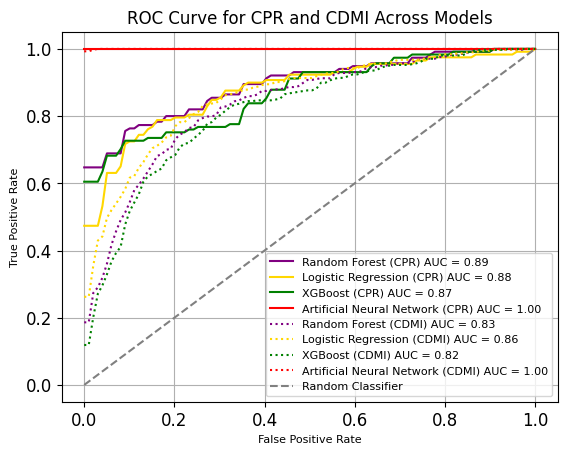

In [ ]:

def get_roc_auc_kfold(model, X, y, cv):
    fpr_list, tpr_list, auc_scores = [], [], []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = model.predict(X_test).flatten()

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)

        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_scores.append(auc_score)

    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for fpr, tpr in zip(fpr_list, tpr_list):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)

    mean_tpr /= len(fpr_list)
    mean_auc = np.mean(auc_scores)

    return mean_fpr, mean_tpr, mean_auc

cv = KFold(n_splits=5, shuffle=True, random_state=42)

fpr_rf_cpr, tpr_rf_cpr, auc_rf_cpr = get_roc_auc_kfold(rf_classifier_CA, X_scaled_NN_CA, y_NN_CA, cv)
fpr_logreg_cpr, tpr_logreg_cpr, auc_logreg_cpr = get_roc_auc_kfold(log_reg_LR_CA, X_scaled_NN_CA, y_NN_CA, cv)
fpr_xgb_cpr, tpr_xgb_cpr, auc_xgb_cpr = get_roc_auc_kfold(xgb_classifier_XG_CA, X_scaled_NN_CA, y_NN_CA, cv)
fpr_nn_cpr, tpr_nn_cpr, auc_nn_cpr = get_roc_auc_kfold(model_NN_CA, X_scaled_NN_CA, y_NN_CA, cv)

fpr_rf_cdmi, tpr_rf_cdmi, auc_rf_cdmi = get_roc_auc_kfold(rf_classifier_CDMI, X_scaled_NN_CDMI, y_NN_CDMI, cv)
fpr_logreg_cdmi, tpr_logreg_cdmi, auc_logreg_cdmi = get_roc_auc_kfold(log_reg_LR_CDMI, X_scaled_NN_CDMI, y_NN_CDMI, cv)
fpr_xgb_cdmi, tpr_xgb_cdmi, auc_xgb_cdmi = get_roc_auc_kfold(xgb_classifier_XG_CDMI, X_scaled_NN_CDMI, y_NN_CDMI, cv)
fpr_nn_cdmi, tpr_nn_cdmi, auc_nn_cdmi = get_roc_auc_kfold(model_NN_CDMI, X_scaled_NN_CDMI, y_NN_CDMI, cv)

plt.plot(fpr_rf_cpr, tpr_rf_cpr, linestyle='-', label=f'Random Forest (CPR) AUC = {auc_rf_cpr:.2f}', color='purple')
plt.plot(fpr_logreg_cpr, tpr_logreg_cpr, linestyle='-', label=f'Logistic Regression (CPR) AUC = {auc_logreg_cpr:.2f}', color='gold')
plt.plot(fpr_xgb_cpr, tpr_xgb_cpr, linestyle='-', label=f'XGBoost (CPR) AUC = {auc_xgb_cpr:.2f}', color='green')
plt.plot(fpr_nn_cpr, tpr_nn_cpr, linestyle='-', label=f'Artificial Neural Network (CPR) AUC = {auc_nn_cpr:.2f}', color='red')

plt.plot(fpr_rf_cdmi, tpr_rf_cdmi, linestyle=':', label=f'Random Forest (CDMI) AUC = {auc_rf_cdmi:.2f}', color='purple')
plt.plot(fpr_logreg_cdmi, tpr_logreg_cdmi, linestyle=':', label=f'Logistic Regression (CDMI) AUC = {auc_logreg_cdmi:.2f}', color='gold')
plt.plot(fpr_xgb_cdmi, tpr_xgb_cdmi, linestyle=':', label=f'XGBoost (CDMI) AUC = {auc_xgb_cdmi:.2f}', color='green')
plt.plot(fpr_nn_cdmi, tpr_nn_cdmi, linestyle=':', label=f'Artificial Neural Network (CDMI) AUC = {auc_nn_cdmi:.2f}', color='red')

plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', label="Random Classifier")

plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('ROC Curve for CPR and CDMI Across Models', fontsize=12)
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.show()